# Обучение моделей

## Импорт библиотек и модулей

In [1]:
# Импортируем модули для работы с операционной системой и случайными числами
import os
import sys
import random
from pathlib import Path
from joblib import dump

# Импортируем модули для визуализации данных
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Импортируем статистические функции
from scipy.stats import randint, uniform, loguniform

# Импортируем функции для моделирования и оценки моделей из библиотеки scikit-learn
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

# Импортируем классификаторы из библиотек xgboost и catboost
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

import optuna
# Импортируем библиотеку TensorFlow и связанные с ней модули
import tensorflow as tf
from tensorflow import random as tf_random
from keras.callbacks import (
    History,
    ModelCheckpoint,
)

from keras.layers import (
    Dense, Flatten, Input, Dropout, BatchNormalization
)

from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical

# Импортируем библиотеку PyTorch и связанные с ней модули
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F


c:\Users\user\AppData\Local\Programs\Python\Python38\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Получаем путь до корня проекта
project_root = Path.cwd().parent  # Переходим на уровень выше от текущей директории

# Добавляем корень проекта в PYTHONPATH
sys.path.append(str(project_root))

# Проверяем, что всё работает
print(f"Добавлено в PYTHONPATH: {project_root}")

Добавлено в PYTHONPATH: c:\Users\user\Documents\Github\My_diplom_work\ECG_Program


In [3]:
from src.utils import const

print("Импорты завершены успешно!")

Импорты завершены успешно!


## Воспроизводимость обучения

In [4]:
# используется для фиксации сучайных значений 
# чтобы обеспечить воспроизводимость результатов в экспериментах,
# связанных со случайными процессами

# Задаем константу для семени случайных чисел
RAND_SEED = 22869420

# Функция для сброса семени случайных чисел
def reset_rand_seed():
    # Устанавливаем семя для хэширования в Python
    os.environ['PYTHONHASHSEED'] = str(RAND_SEED)
    # Устанавливаем семя для модуля random
    random.seed(RAND_SEED)
    # Устанавливаем семя для библиотеки numpy
    np.random.seed(RAND_SEED)
    # Устанавливаем семя для случайных чисел в TensorFlow
    tf_random.set_seed(RAND_SEED)


## Получение данных

In [5]:
# Считываем CSV-файл с дескрипторами и загружаем его в DataFrame
descriptors_df = pd.read_csv(os.path.abspath(os.path.join('..', 'dataset', 'descriptors.csv')))
# Считываем CSV-файл с метками и загружаем его в DataFrame
labels_df = pd.read_csv(os.path.abspath(os.path.join('..', 'dataset', 'labels.csv')))


### Описание данных

In [6]:
# Выводим первые 5 строк из DataFrame descriptors_df для предварительного просмотра данных
descriptors_df.head(5)
# Выводим статистическое описание данных в DataFrame descriptors_df
descriptors_df.describe()


,cc00,cc01,cc02,cc03,cc04,cc05,cc06,cc07,cc08,cc09,cc10,cc11,zcr,entropy
count,7054.000000,7054.000000,7054.000000,7054.000000,7054.000000,7054.000000,7054.000000,7054.000000,7054.000000,7054.000000,7054.000000,7054.000000,7054.000000,7054.000000
mean,-14.797222,3.584844,0.390813,-0.064841,0.278776,0.693150,0.469888,0.139350,0.120219,0.298385,0.260497,0.072855,10.149419,1.636323
std,0.818917,0.507552,0.247229,0.314191,0.186303,0.201450,0.153156,0.169193,0.140690,0.141315,0.127901,0.137939,5.470394,0.087396
min,-17.608148,2.045800,-0.608530,-1.731450,-0.769442,0.057170,-0.261591,-0.831262,-0.542616,-0.385176,-0.293737,-0.853053,0.000000,0.313229
25%,-15.343579,3.216286,0.233976,-0.235513,0.171551,0.556045,0.375015,0.050853,0.036496,0.205593,0.180339,-0.003999,6.000000,1.585722
50%,-14.768767,3.525823,0.390761,-0.012340,0.289905,0.673057,0.471691,0.158119,0.126930,0.285852,0.257284,0.088089,8.000000,1.644424
75%,-14.282198,3.875723,0.548848,0.160152,0.394124,0.818840,0.565124,0.252188,0.206892,0.382333,0.340159,0.162926,12.000000,1.694402
max,-9.121267,6.534010,1.530751,0.750382,1.183244,1.458471,1.109853,0.668554,0.785899,0.982043,0.784795,0.547661,48.000000,1.889197


In [7]:
# Объединяем DataFrame descriptors_df и labels_df по столбцам
data = pd.concat([descriptors_df, labels_df], axis=1)
# Выводим последние 5 строк из объединенного DataFrame data для просмотра данных
data.tail(5)


,cc00,cc01,cc02,cc03,cc04,cc05,cc06,cc07,cc08,cc09,cc10,cc11,zcr,entropy,person_id
7049,-16.160150,4.258321,0.374531,-0.144153,0.666729,1.232982,0.476558,-0.240718,-0.150608,0.181882,0.222640,0.312680,10.0,1.683011,89
7050,-16.008320,4.432666,0.417492,-0.695739,0.437030,1.066404,0.593969,0.098892,0.346299,0.544776,0.129412,-0.004448,8.0,1.620802,89
7051,-16.029840,4.459116,0.023741,-0.876512,-0.082003,1.126998,0.696040,0.050741,-0.047132,0.393095,0.449917,0.267388,10.0,1.764125,89
7052,-15.908913,4.811540,0.448647,-0.574619,0.561361,1.076380,0.486817,-0.284838,0.033955,0.373390,0.150314,-0.221511,9.0,1.716962,89
7053,-16.197072,4.559458,0.344763,-0.544261,0.520440,1.202703,0.603785,-0.204143,0.463820,0.549303,0.039825,-0.465035,5.0,1.652621,89


# Разделение данных на тренировочную, валидационную и тестовую выборки и стандартизация данных

In [8]:
# Преобразуем DataFrame descriptors_df в массив numpy с типом данных float
X = descriptors_df.to_numpy(dtype=float)
# Преобразуем DataFrame labels_df в одномерный массив numpy с типом данных int и "развертываем" массив
y = labels_df.to_numpy(dtype=int).flatten()

# Разделяем данные на тренировочную, тестовую и валидационную выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
X_test, X_val, y_test, y_val = train_test_split(
    X_test, y_test, test_size=0.5, random_state=42
)

# Стандартизируем данные и перезаписываем переменные
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  # Перезаписываем X_train
X_test = scaler.transform(X_test)        # Перезаписываем X_test
X_val = scaler.transform(X_val)          # Перезаписываем X_val


In [9]:
example=pd.DataFrame(X_train)
example.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
count,5.643000e+03,5.643000e+03,5.643000e+03,5.643000e+03,5.643000e+03,5.643000e+03,5.643000e+03,5.643000e+03,5.643000e+03,5.643000e+03,5.643000e+03,5.643000e+03,5.643000e+03,5.643000e+03
mean,4.627279e-14,1.044031e-14,3.996567e-15,-7.769004e-16,1.271749e-16,6.547620e-16,4.775041e-15,-2.974131e-15,6.812044e-16,-4.582075e-15,3.392171e-15,8.247483e-16,-1.007326e-16,4.300024e-14
std,1.000089e+00,1.000089e+00,1.000089e+00,1.000089e+00,1.000089e+00,1.000089e+00,1.000089e+00,1.000089e+00,1.000089e+00,1.000089e+00,1.000089e+00,1.000089e+00,1.000089e+00,1.000089e+00
min,-3.352707e+00,-3.034914e+00,-4.036807e+00,-5.286649e+00,-4.270652e+00,-3.153548e+00,-4.766235e+00,-5.729559e+00,-4.689784e+00,-4.795104e+00,-4.351931e+00,-6.783382e+00,-1.852149e+00,-1.014211e+01
25%,-6.637802e-01,-7.233820e-01,-6.279849e-01,-5.437105e-01,-5.700774e-01,-6.759027e-01,-6.224011e-01,-5.225641e-01,-5.862671e-01,-6.613440e-01,-6.192896e-01,-5.564912e-01,-7.496709e-01,-5.889916e-01
50%,3.787817e-02,-1.204255e-01,-9.742950e-04,1.725076e-01,5.841558e-02,-9.954045e-02,1.684756e-02,1.174316e-01,4.465198e-02,-9.079620e-02,-1.840985e-02,1.144148e-01,-3.821781e-01,8.967053e-02
75%,6.352494e-01,5.793714e-01,6.377742e-01,7.144643e-01,6.147810e-01,6.140521e-01,6.291879e-01,6.654053e-01,6.136377e-01,5.946373e-01,6.189709e-01,6.578776e-01,3.528074e-01,6.688215e-01
max,6.916904e+00,5.839367e+00,4.608799e+00,2.581645e+00,4.822625e+00,3.809189e+00,4.181515e+00,3.121734e+00,4.315286e+00,4.809532e+00,4.130772e+00,3.003447e+00,6.967677e+00,2.924547e+00


In [10]:
print("mean:", scaler.mean_)
print("std:", np.sqrt(scaler.var_))

mean: [-14.80215571   3.58072283   0.39034362  -0.06392489   0.27889389
   0.69184416   0.46894139   0.13958874   0.12036389   0.2974066
   0.25958867   0.07376252  10.07992203   1.63585921]
std: [0.82130508 0.50575475 0.24744141 0.31542189 0.18752232 0.20125731
 0.15327251 0.16944599 0.14136679 0.14234983 0.12714492 0.13663034
 5.44228421 0.08662473]


# Конфигурации для моделей машинного обучения

In [50]:
# Параметры для всех моделей (можно менять числовые параметры и смтореть как измениться модель )
# Конфигурации для различных моделей классификаторов
MODELS_CONFIG = {
    'CatBoost': {
        'class': CatBoostClassifier,  # Используем классификатор CatBoost
        'params': {  # Параметры для настройки модели
            'iterations': randint(100, 500),  # Количество итераций
            'depth': randint(3, 10),  # Глубина деревьев
            'learning_rate': uniform(0.001, 0.01),  # Скорость обучения
            'l2_leaf_reg': uniform(1, 6),  # Регуляризация L2 для листьев деревьев
            'silent': True  # Тихий режим
        }
    },
    'XGBoost': {
        'class': XGBClassifier,  # Используем классификатор XGBoost
        'params': {  # Параметры для настройки модели
            'max_depth': randint(3, 10),  # Максимальная глубина деревьев
            'learning_rate': uniform(0.01, 0.3),  # Скорость обучения
            'n_estimators': randint(50, 500),  # Количество деревьев
            'subsample': uniform(0.5, 0.5),  # Доля выборки для подвыборки
            'colsample_bytree': uniform(0.5, 0.5)  # Доля признаков для каждого дерева
        }
    },
    'RandomForest': {
        'class': RandomForestClassifier,  # Используем классификатор Random Forest
        'params': {  # Параметры для настройки модели
            'n_estimators': randint(50, 500),  # Количество деревьев
            'max_depth': randint(3, 20),  # Максимальная глубина деревьев
            'min_samples_split': randint(2, 10),  # Минимальное количество образцов для разделения узла
            'min_samples_leaf': randint(1, 5),  # Минимальное количество образцов на лист
            'criterion': ['gini', 'entropy']  # Критерий для оценки качества разбиения
        }
    },
    'SVM': {
        'class': SVC,  # Используем метод опорных векторов (SVM)
        'params': {  # Параметры для настройки модели
            'C': uniform(0.1, 10),  # Параметр регуляризации
            'kernel': ['linear', 'rbf', 'poly'],  # Тип ядра
            'gamma': ['scale', 'auto'] + list(np.logspace(-3, 1, 5)),  # Коэффициент ядра
            'degree': randint(2, 5)  # Степень полиномиального ядра
        }
    }
}


In [51]:
def plot_metrics(model_name, model, X_val, y_val, X_test, y_test):
    '''Рисуем графики'''
    plt.figure(figsize=(12, 10))
    
    # График важности признаков
    if hasattr(model, 'feature_importances_'):
        plt.subplot(2, 2, 1)
        feat_importances = pd.Series(model.feature_importances_, index=descriptors_df.columns)
        feat_importances.nlargest(10).plot(kind='barh')
        plt.title(f'Top 10 Features ({model_name})')
    
    # Матрица ошибок (валидационная выборка)
    plt.subplot(2, 2, 2)
    y_val_pred = model.predict(X_val)
    cm_val = confusion_matrix(y_val, y_val_pred)
    sns.heatmap(cm_val, annot=True, cmap='Blues', fmt='d')
    plt.title(f'Confusion Matrix (Validation)')
    
    # Матрица ошибок (тестовая выборка)
    plt.subplot(2, 2, 3)
    y_test_pred = model.predict(X_test)
    cm_test = confusion_matrix(y_test, y_test_pred)
    sns.heatmap(cm_test, annot=True, cmap='Blues', fmt='d')
    plt.title(f'Confusion Matrix (Test)')
    
    plt.tight_layout()
    plt.show()

def train_selected_model(model_name):
    if model_name not in MODELS_CONFIG:
        available_models = ', '.join(MODELS_CONFIG.keys())
        raise ValueError(f"Неизвестная модель: {model_name}. Доступные модели: {available_models}")
    
    config = MODELS_CONFIG[model_name]
    print(f"\n{'-'*40}")
    print(f"Обучение модели {model_name}...")
    
    # Для CatBoost отключаем вывод
    if model_name == 'CatBoost':
        config['params']['silent'] = [True]
    
    # Создаем объект RandomizedSearchCV для поиска лучших параметров модели
    search = RandomizedSearchCV(
        config['class'](),  # Класс модели
        config['params'],  # Параметры для поиска
        n_iter=15 if model_name == 'SVM' else 20,  # Количество итераций поиска
        scoring='accuracy',  # Метрика для оценки моделей
        n_jobs=2,  # Количество параллельных задач
        cv=3,  # Количество кросс-валидаций
        random_state=42  # Случайное состояние для воспроизводимости
    )
    
    # Обучаем модель на тренировочных данных
    search.fit(X_train, y_train)
    best_model = search.best_estimator_
    
    # Оценка модели на валидационной выборке
    y_val_pred = best_model.predict(X_val)
    val_accuracy = accuracy_score(y_val, y_val_pred)
    print(f"\nЛучшие параметры: {search.best_params_}")
    print(f"Validation Accuracy: {val_accuracy:.3f}")
    print("Classification Report (Validation):")
    print(classification_report(y_val, y_val_pred))
    
    # Оценка модели на тестовой выборке
    y_test_pred = best_model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    print(f"\nTest Accuracy: {test_accuracy:.3f}")
    print("Classification Report (Test):")
    print(classification_report(y_test, y_test_pred))
    
    # Визуализация
    plot_metrics(model_name, best_model, X_val, y_val, X_test, y_test)
    return best_model


### Обучение модели CatBoost

Лучшие параметры: {'depth': 8, 'iterations': 393, 'l2_leaf_reg': 1.004672595046086, 'learning_rate': 0.010922115592912174, 'silent': True}
Accuracy: 0.485


----------------------------------------
Обучение модели CatBoost...


C:\Users\Digital Razor\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



Лучшие параметры: {'depth': 8, 'iterations': 393, 'l2_leaf_reg': 1.004672595046086, 'learning_rate': 0.010922115592912174, 'silent': True}
Accuracy: 0.454
              precision    recall  f1-score   support

           0       0.34      0.57      0.42        51
           1       0.34      0.80      0.48        49
           2       0.27      0.18      0.21        17
           3       0.33      0.25      0.29         4
           4       0.33      1.00      0.50         1
           5       0.40      0.25      0.31         8
           6       0.75      0.60      0.67         5
           7       0.17      0.17      0.17         6
           8       0.35      0.50      0.41        14
           9       0.18      0.12      0.15        16
          10       0.50      0.60      0.55        10
          11       0.71      0.71      0.71         7
          12       0.00      0.00      0.00         2
          13       0.60      0.60      0.60         5
          14       0.00      0.00

C:\Users\Digital Razor\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Digital Razor\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Digital Razor\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklea

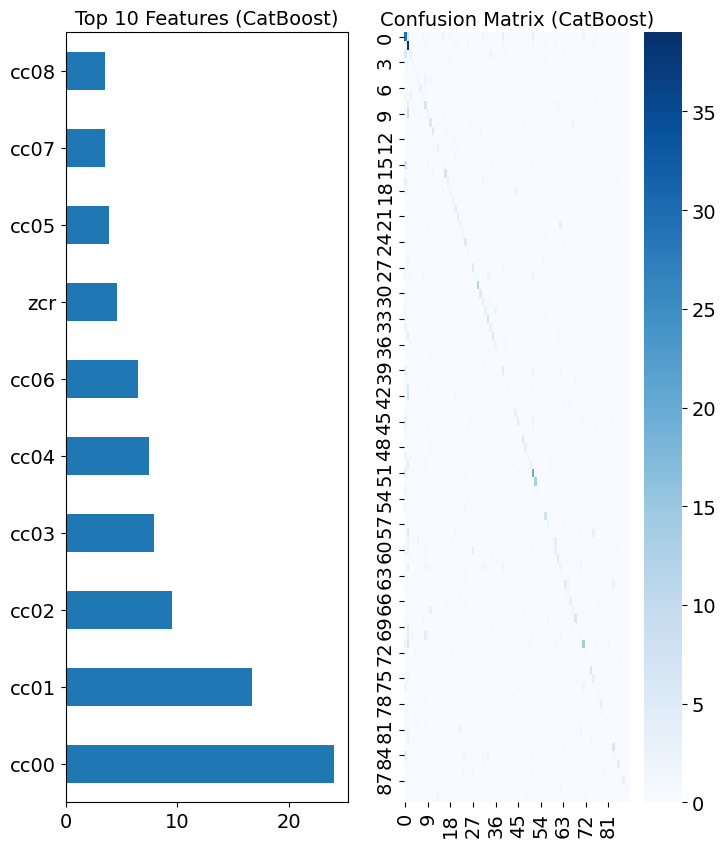

In [145]:
# Пример использования:
model = train_selected_model('CatBoost')

### Обучение модели XGBoost

Лучшие параметры: {'colsample_bytree': 0.8925879806965068, 'learning_rate': 0.06990213464750791, 'max_depth': 9, 'n_estimators': 293, 'subsample': 0.7962072844310213}
Accuracy: 0.497


----------------------------------------
Обучение модели XGBoost...

Лучшие параметры: {'colsample_bytree': 0.6154469128110744, 'learning_rate': 0.0823076398078035, 'max_depth': 6, 'n_estimators': 477, 'subsample': 0.7475884550556351}
Accuracy: 0.477
              precision    recall  f1-score   support

           0       0.34      0.49      0.40        51
           1       0.36      0.71      0.48        49
           2       0.25      0.24      0.24        17
           3       0.50      0.25      0.33         4
           4       0.25      1.00      0.40         1
           5       0.50      0.38      0.43         8
           6       0.50      0.60      0.55         5
           7       0.20      0.17      0.18         6
           8       0.38      0.36      0.37        14
           9       0.25      0.12      0.17        16
          10       0.42      0.50      0.45        10
          11       1.00      0.86      0.92         7
          12       0.50      0.50      0.50  

C:\Users\Digital Razor\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Digital Razor\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Digital Razor\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklea

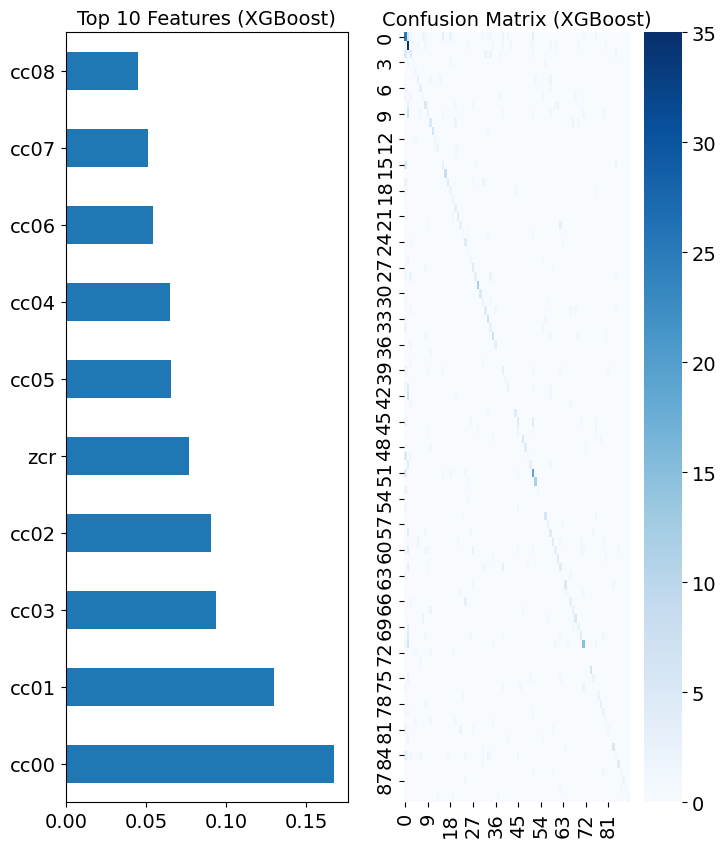

In [144]:
# Обучаем модель с использованием XGBoost и сохраняем лучший обученный классификатор
model = train_selected_model('XGBoost')


### Обучение модели RandomForest

Лучшие параметры: {'criterion': 'gini', 'max_depth': 16, 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 314}
Accuracy: 0.493


----------------------------------------
Обучение модели RandomForest...

Лучшие параметры: {'criterion': 'gini', 'max_depth': 16, 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 314}
Accuracy: 0.471
              precision    recall  f1-score   support

           0       0.34      0.57      0.43        51
           1       0.34      0.82      0.48        49
           2       0.25      0.18      0.21        17
           3       0.50      0.25      0.33         4
           4       0.25      1.00      0.40         1
           5       0.17      0.12      0.14         8
           6       0.67      0.80      0.73         5
           7       0.17      0.17      0.17         6
           8       0.57      0.57      0.57        14
           9       0.25      0.12      0.17        16
          10       0.50      0.60      0.55        10
          11       0.86      0.86      0.86         7
          12       0.00      0.00      0.00         2
          13       0.60    

C:\Users\Digital Razor\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Digital Razor\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Digital Razor\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklea

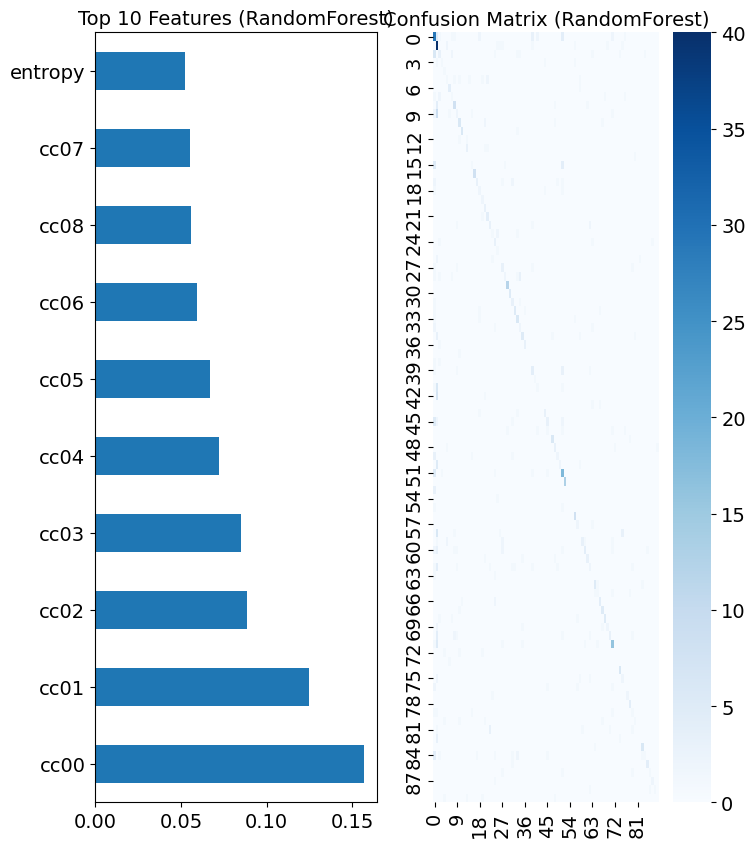

In [146]:
# Обучаем модель с использованием RandomForest и сохраняем лучший обученный классификатор
model = train_selected_model('RandomForest')


### Обучение модели SVM

Лучшие параметры: {'C': 8.18397348116461, 'degree': 2, 'gamma': 'auto', 'kernel': 'linear'}
Accuracy: 0.530


----------------------------------------
Обучение модели SVM...

Лучшие параметры: {'C': 8.18397348116461, 'degree': 2, 'gamma': 'auto', 'kernel': 'linear'}
Validation Accuracy: 0.562
Classification Report (Validation):
              precision    recall  f1-score   support

           0       0.47      0.76      0.58        51
           1       0.43      0.90      0.58        48
           2       0.45      0.45      0.45        11
           3       0.25      0.33      0.29         3
           4       0.33      0.50      0.40         4
           5       0.25      0.14      0.18         7
           6       0.33      1.00      0.50         1
           7       0.50      0.33      0.40         3
           8       0.68      0.85      0.76        20
           9       0.67      0.38      0.48        16
          10       0.17      0.25      0.20         4
          11       0.60      0.50      0.55         6
          12       0.00      0.00      0.00         1
          13       0.5

C:\Users\Digital Razor\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Digital Razor\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Digital Razor\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklea


Test Accuracy: 0.498
Classification Report (Test):
              precision    recall  f1-score   support

           0       0.37      0.71      0.49        51
           1       0.37      0.76      0.50        49
           2       0.44      0.41      0.42        17
           3       0.00      0.00      0.00         4
           4       0.00      0.00      0.00         1
           5       0.25      0.25      0.25         8
           6       0.50      0.60      0.55         5
           7       0.20      0.17      0.18         6
           8       0.46      0.43      0.44        14
           9       0.30      0.19      0.23        16
          10       0.36      0.40      0.38        10
          11       0.83      0.71      0.77         7
          12       0.50      0.50      0.50         2
          13       0.50      0.40      0.44         5
          14       0.00      0.00      0.00         1
          15       0.25      0.09      0.13        11
          16       1.00      

C:\Users\Digital Razor\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Digital Razor\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Digital Razor\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklea

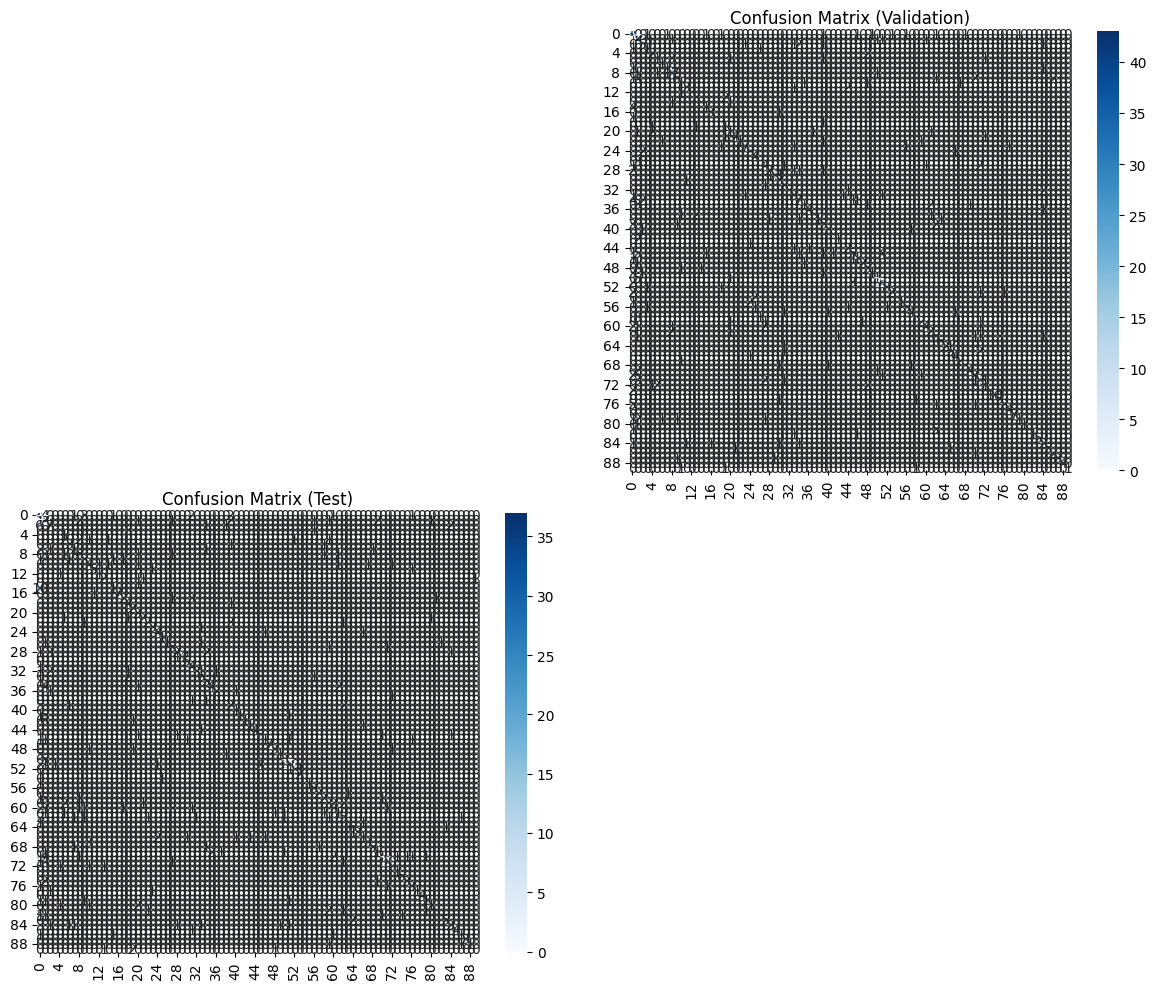

In [52]:
# Обучаем модель с использованием метода опорных векторов (SVM) и сохраняем лучший обученный классификатор
model = train_selected_model('SVM')


## SVM

linear accuracy:	45.29%
poly accuracy:	41.44%
rbf accuracy:	38.94%
sigmoid accuracy:	7.31%


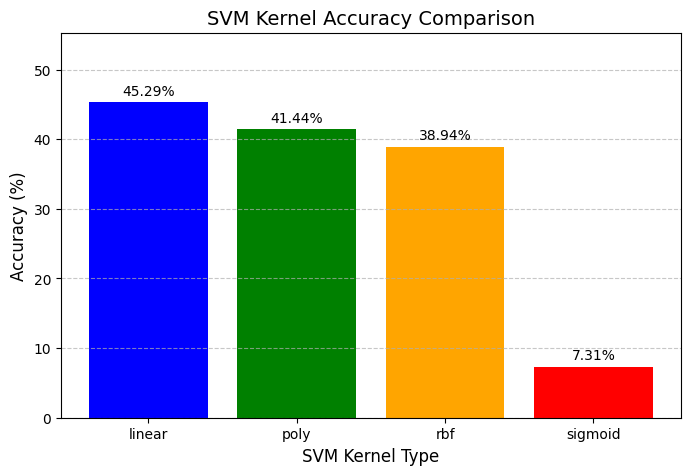

In [53]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

# Определяем список ядер для SVM
kernels = ["linear", "poly", "rbf", "sigmoid"]

# Создаем список для хранения классификаторов и их ядер
clfs = []
accuracies = []  # Список для хранения точностей

for kernel in kernels:
    # Добавляем кортеж, содержащий классификатор SVC с заданным ядром и название ядра
    clfs.append((SVC(gamma=1, kernel=kernel, random_state=RAND_SEED, max_iter=10_000), kernel))

# Проходим по списку классификаторов и их ядер
for clf, kernel in clfs:
    # Сбрасываем семя случайных чисел для воспроизводимости
    reset_rand_seed()
    
    # Выполняем кросс-валидацию и вычисляем оценки точности для каждого классификатора
    scores = cross_val_score(clf, X, y, n_jobs=-1, scoring='accuracy')
    
    # Сохраняем среднюю точность для текущего ядра
    accuracies.append(np.mean(scores) * 100)  # Умножаем на 100 для представления в процентах

    # Выводим среднюю точность для каждого ядра
    print(f'{kernel} accuracy:\t{np.mean(scores):0.2%}')

# Построение гистограммы на основе полученных данных
plt.figure(figsize=(8, 5))
plt.bar(kernels, accuracies, color=['blue', 'green', 'orange', 'red'])

# Добавление подписей и заголовка
plt.xlabel('SVM Kernel Type', fontsize=12)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.title('SVM Kernel Accuracy Comparison', fontsize=14)
plt.ylim(0, max(accuracies) + 10)  # Устанавливаем верхнюю границу оси Y немного выше максимального значения
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Показываем точные значения точности над столбиками
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 1, f'{acc:.2f}%', ha='center', fontsize=10, color='black')

# Отображение графика
plt.show()



# Обучение нейронных сетей

## 1. SKLearn neural network

In [138]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform

# Функция для создания MLPClassifier с гибкой архитектурой
def create_mlp_model(layer_config='auto', input_dim=None, 
                     activation='relu', solver='adam', 
                     alpha=0.0001, learning_rate='constant',
                     max_iter=1000, early_stopping=True,
                     random_state=None):
    """
    Создает MLPClassifier с гибкой архитектурой
    """
    if layer_config == 'auto' and input_dim:
        # Автоматическая генерация архитектуры на основе размерности данных
        base_size = max(32, input_dim // 4)
        hidden_layers = (
            base_size * 8, 
            base_size * 4,
            base_size * 2,
            base_size,
            max(2, base_size // 2)
        )
    elif isinstance(layer_config, (list, tuple)):
        hidden_layers = layer_config
    else:
        hidden_layers = (128, 256, 128, 64)  # Дефолтная архитектура
    
    return MLPClassifier(
        hidden_layer_sizes=hidden_layers,
        activation=activation,
        solver=solver,
        alpha=alpha,
        learning_rate=learning_rate,
        max_iter=max_iter,
        early_stopping=early_stopping,
        random_state=random_state,
        verbose=True  # Включение вывода процесса обучения
    )

# Функция для визуализации кривой обучения
def plot_learning_curve(mlp, X_val, y_val, X_test, y_test):
    """Визуализация кривой обучения"""
    plt.figure(figsize=(18, 6))
    
    # График потерь
    plt.subplot(1, 3, 1)
    plt.plot(mlp.loss_curve_, label='Training Loss')
    plt.title('Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    # График точности на валидационной выборке
    if hasattr(mlp, 'validation_scores_'):
        plt.subplot(1, 3, 2)
        plt.plot(mlp.validation_scores_, label='Validation Accuracy')
        plt.title('Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
    
    # График точности на тестовой выборке
    test_accuracy = []
    for i in range(len(mlp.loss_curve_)):
        # Имитация предсказания на тестовой выборке после каждой эпохи
        y_pred_test = mlp.predict(X_test)
        test_accuracy.append(accuracy_score(y_test, y_pred_test))
    
    plt.subplot(1, 3, 3)
    plt.plot(test_accuracy, label='Test Accuracy', color='orange')
    plt.title('Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Функция для обучения модели с подбором гиперпараметров
def train_mlp(X_train, y_train, X_val, y_val, X_test, y_test, 
              param_dist=None, n_iter=20, cv=3):
    """
    Обучение модели с подбором гиперпараметров
    """
    reset_rand_seed()
    
    # Дефолтное пространство параметров для поиска
    if param_dist is None:
        param_dist = {
            'hidden_layer_sizes': [
                (256, 128, 64),
                (512, 256, 128),
                (128, 64, 32),
                (256, 128, 64, 32),
                (512, 256, 128, 64)
            ],
            'activation': ['relu', 'tanh', 'logistic'],
            'solver': ['adam', 'sgd'],
            'alpha': loguniform(1e-5, 1e-2),
            'learning_rate_init': loguniform(1e-4, 1e-2),
            'batch_size': [32, 64, 128, 256]
        }
    
    mlp = MLPClassifier(max_iter=1000, early_stopping=True)
    
    search = RandomizedSearchCV(
        mlp,
        param_distributions=param_dist,
        n_iter=n_iter,
        cv=cv,
        n_jobs=1,
        scoring='accuracy',
        random_state=RAND_SEED
    )
    
    search.fit(X_train, y_train)
    
    best_mlp = search.best_estimator_
    
    # Дотренировка на полном наборе данных
    best_mlp.max_iter += 500
    best_mlp.fit(X_train, y_train)
    
    # Оценка качества
    y_pred_val = best_mlp.predict(X_val)
    y_pred_test = best_mlp.predict(X_test)
    
    print(f"Best parameters: {search.best_params_}")
    print(f"Validation Accuracy: {accuracy_score(y_val, y_pred_val):.3f}")
    print(f"Test Accuracy: {accuracy_score(y_test, y_pred_test):.3f}")
    print("Validation Classification Report:")
    print(classification_report(y_val, y_pred_val))
    print("Test Classification Report:")
    print(classification_report(y_test, y_pred_test))
    
    # Визуализации
    plot_learning_curve(best_mlp, X_val, y_val, X_test, y_test)
    
    cm_val = confusion_matrix(y_val, y_pred_val)
    cm_test = confusion_matrix(y_test, y_pred_test)
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    ConfusionMatrixDisplay(cm_val).plot(include_values=False, cmap='Blues', ax=axes[0])
    axes[0].set_title('Validation Confusion Matrix')
    ConfusionMatrixDisplay(cm_test).plot(include_values=False, cmap='Blues', ax=axes[1])
    axes[1].set_title('Test Confusion Matrix')
    plt.tight_layout()
    plt.show()
    
    return best_mlp

Автоматический подбор параметров



Best parameters: {'activation': 'tanh', 'alpha': 0.00018856783874794973, 'batch_size': 64, 'hidden_layer_sizes': (512, 256, 128), 'learning_rate_init': 0.0013658426050382536, 'solver': 'adam'}
Validation Accuracy: 0.602
Test Accuracy: 0.550
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.71      0.64        51
           1       0.56      0.73      0.63        48
           2       0.32      0.55      0.40        11
           3       0.50      0.33      0.40         3
           4       0.40      0.50      0.44         4
           5       0.50      0.29      0.36         7
           6       0.33      1.00      0.50         1
           7       0.25      0.33      0.29         3
           8       0.82      0.70      0.76        20
           9       0.62      0.50      0.55        16
          10       0.17      0.25      0.20         4
          11       0.83      0.83      0.83         6
          12       0.0

C:\Users\Digital Razor\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Digital Razor\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Digital Razor\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklea

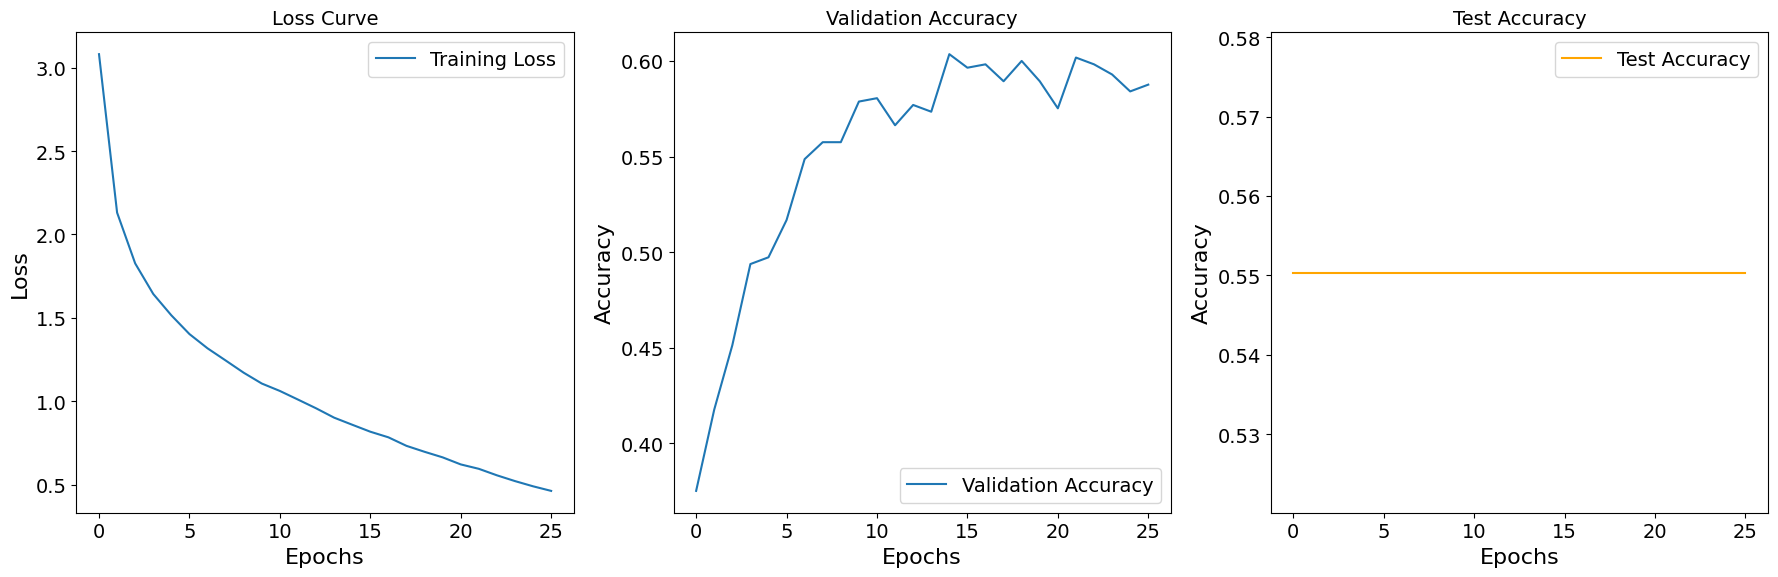

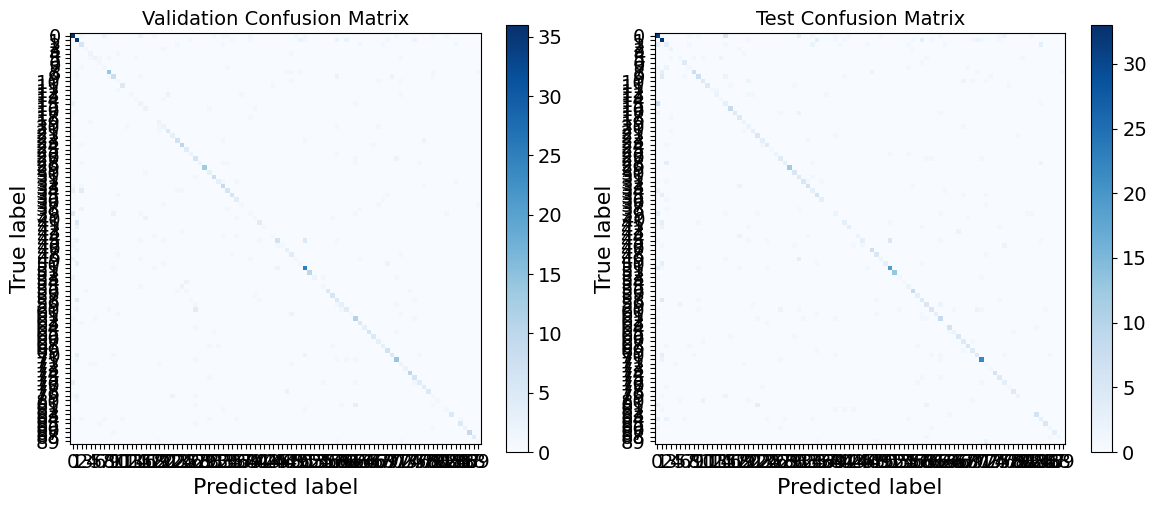

In [139]:
# 1. Автоматический подбор параметров с использованием трех выборок
best_model = train_mlp(X_train, y_train, X_val, y_val, X_test, y_test)

Ручная настройка

In [140]:
# 2. Ручная настройка архитектуры
# Создаем MLPClassifier с указанной архитектурой и параметрами
custom_mlp = create_mlp_model(
    layer_config=(512, 256, 128, 64, 32),  # Настройка слоев сети
    activation='tanh',  # Функция активации
    learning_rate='adaptive',  # Адаптивная скорость обучения
    max_iter=2000  # Максимальное количество итераций обучения
)

# Обучаем MLPClassifier на тренировочных данных
custom_mlp.fit(X_train, y_train)

# Оцениваем модель на валидационной выборке
val_accuracy = custom_mlp.score(X_val, y_val)
print(f"Validation Accuracy: {val_accuracy:.4f}")

# Оцениваем модель на тестовой выборке
test_accuracy = custom_mlp.score(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Если необходимо, можно также вывести дополнительные метрики
from sklearn.metrics import classification_report

# Предсказания на валидационной выборке
y_val_pred = custom_mlp.predict(X_val)
print("Validation Classification Report:")
print(classification_report(y_val, y_val_pred))

# Предсказания на тестовой выборке
y_test_pred = custom_mlp.predict(X_test)
print("Test Classification Report:")
print(classification_report(y_test, y_test_pred))


Iteration 1, loss = 4.12992053
Validation score: 0.180531
Iteration 2, loss = 3.68137469
Validation score: 0.240708
Iteration 3, loss = 3.35693412
Validation score: 0.274336
Iteration 4, loss = 3.10272743
Validation score: 0.307965
Iteration 5, loss = 2.88721521
Validation score: 0.329204
Iteration 6, loss = 2.70579085
Validation score: 0.359292
Iteration 7, loss = 2.55084396
Validation score: 0.368142
Iteration 8, loss = 2.41642355
Validation score: 0.400000
Iteration 9, loss = 2.31109761
Validation score: 0.426549
Iteration 10, loss = 2.19887884
Validation score: 0.430088
Iteration 11, loss = 2.10558804
Validation score: 0.438938
Iteration 12, loss = 2.02193169
Validation score: 0.454867
Iteration 13, loss = 1.95002662
Validation score: 0.451327
Iteration 14, loss = 1.88118762
Validation score: 0.474336
Iteration 15, loss = 1.81512457
Validation score: 0.486726
Iteration 16, loss = 1.76211079
Validation score: 0.486726
Iteration 17, loss = 1.70555442
Validation score: 0.495575
Iterat

C:\Users\Digital Razor\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Digital Razor\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Digital Razor\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklea

## 2. TensorFlow neural network

In [11]:
# Проверка доступности GPU
print("Доступные GPU:", tf.config.list_physical_devices('GPU'))

Доступные GPU: []


# Обучение с адаптивным подбором параметров

In [12]:
# Функция создания модели
def create_optimized_model(input_shape, num_classes, params):
    model = Sequential([
        Dense(params['dense_units_1'], activation='relu', input_shape=input_shape,
              kernel_regularizer=tf.keras.regularizers.l2(params['l2_reg'])),
        BatchNormalization(),
        Dropout(params['dropout_rate_1']),

        Dense(params['dense_units_2'], activation='relu',
              kernel_regularizer=tf.keras.regularizers.l2(params['l2_reg'])),
        BatchNormalization(),
        Dropout(params['dropout_rate_2']),

        Dense(params['dense_units_3'], activation='relu',
              kernel_regularizer=tf.keras.regularizers.l2(params['l2_reg'])),
        BatchNormalization(),
        Dropout(params['dropout_rate_3']),

        Dense(params['dense_units_4'], activation='relu'),
        Dense(num_classes, activation='softmax')
    ])

    optimizer = Adam(learning_rate=params['learning_rate'])

    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


# Целевая функция для Optuna
def objective(trial, X_train, y_train, X_val, y_val):
    params = {
        'dense_units_1': trial.suggest_int('dense_units_1', 128, 512),
        'dense_units_2': trial.suggest_int('dense_units_2', 64, 256),
        'dense_units_3': trial.suggest_int('dense_units_3', 64, 256),
        'dense_units_4': trial.suggest_int('dense_units_4', 32, 128),
        'dropout_rate_1': trial.suggest_float('dropout_rate_1', 0.2, 0.7),
        'dropout_rate_2': trial.suggest_float('dropout_rate_2', 0.2, 0.6),
        'dropout_rate_3': trial.suggest_float('dropout_rate_3', 0.1, 0.5),
        'l2_reg': trial.suggest_float('l2_reg', 1e-5, 1e-2, log=True),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    }

    model = create_optimized_model((X_train.shape[1],), len(np.unique(y_train)), params)

    callbacks = [
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
    ]

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=100,
        batch_size=64,
        callbacks=callbacks,
        verbose=0
    )

    # Предсказания на валидации для F1
    y_val_pred = np.argmax(model.predict(X_val, verbose=0), axis=1)
    val_f1 = f1_score(y_val, y_val_pred, average='macro')

    print(f"[Trial {trial.number}] Val F1: {val_f1:.4f} | Params: {params}")
    return 1.0 - val_f1  # минимизируем ошибку (1 - F1)


# === Запуск Optuna ===
study = optuna.create_study(direction='minimize', pruner=optuna.pruners.MedianPruner())
study.optimize(lambda trial: objective(trial, X_train, y_train, X_val, y_val), n_trials=20)

print("\nЛучшие параметры:", study.best_params)
print("Лучшая ошибка (1 - F1):", study.best_value)

# === Обучение финальной модели на лучших параметрах ===
best_params = study.best_params
final_model = create_optimized_model((X_train.shape[1],), len(np.unique(y_train)), best_params)
final_model._name = 'ECGPersonIdentifier'

callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
]

history = final_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=150,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)

# === Оценка на тесте ===
y_pred = final_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

test_f1 = f1_score(y_test, y_pred_classes, average='macro')
test_acc = np.mean(y_pred_classes == y_test)
test_loss = final_model.evaluate(X_test, y_test, verbose=0)[0]

print(f"\nTest Accuracy: {test_acc:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")
print(f"Test Loss: {test_loss:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes, zero_division=0))

[I 2025-05-27 00:40:03,821] A new study created in memory with name: no-name-47f3d755-fcc1-4dfe-bb2f-e2fd288ae844
[I 2025-05-27 00:40:42,570] Trial 0 finished with value: 0.3818212446217617 and parameters: {'dense_units_1': 480, 'dense_units_2': 132, 'dense_units_3': 178, 'dense_units_4': 40, 'dropout_rate_1': 0.4552035032791859, 'dropout_rate_2': 0.44256200092602, 'dropout_rate_3': 0.14225537507788416, 'l2_reg': 0.00010039136425836217, 'learning_rate': 0.0006215047704308997}. Best is trial 0 with value: 0.3818212446217617.


[Trial 0] Val F1: 0.6182 | Params: {'dense_units_1': 480, 'dense_units_2': 132, 'dense_units_3': 178, 'dense_units_4': 40, 'dropout_rate_1': 0.4552035032791859, 'dropout_rate_2': 0.44256200092602, 'dropout_rate_3': 0.14225537507788416, 'l2_reg': 0.00010039136425836217, 'learning_rate': 0.0006215047704308997}


[I 2025-05-27 00:41:31,524] Trial 1 finished with value: 0.4024621290462793 and parameters: {'dense_units_1': 503, 'dense_units_2': 186, 'dense_units_3': 174, 'dense_units_4': 120, 'dropout_rate_1': 0.6637780953843753, 'dropout_rate_2': 0.2167795243444398, 'dropout_rate_3': 0.27745009942083887, 'l2_reg': 0.003483307808095086, 'learning_rate': 0.001963963997129992}. Best is trial 0 with value: 0.3818212446217617.


[Trial 1] Val F1: 0.5975 | Params: {'dense_units_1': 503, 'dense_units_2': 186, 'dense_units_3': 174, 'dense_units_4': 120, 'dropout_rate_1': 0.6637780953843753, 'dropout_rate_2': 0.2167795243444398, 'dropout_rate_3': 0.27745009942083887, 'l2_reg': 0.003483307808095086, 'learning_rate': 0.001963963997129992}


[I 2025-05-27 00:42:20,939] Trial 2 finished with value: 0.46653795237196105 and parameters: {'dense_units_1': 468, 'dense_units_2': 172, 'dense_units_3': 119, 'dense_units_4': 115, 'dropout_rate_1': 0.3693867976385322, 'dropout_rate_2': 0.2304946717372625, 'dropout_rate_3': 0.3875733831472653, 'l2_reg': 1.4587019569080757e-05, 'learning_rate': 0.00010129025768100391}. Best is trial 0 with value: 0.3818212446217617.


[Trial 2] Val F1: 0.5335 | Params: {'dense_units_1': 468, 'dense_units_2': 172, 'dense_units_3': 119, 'dense_units_4': 115, 'dropout_rate_1': 0.3693867976385322, 'dropout_rate_2': 0.2304946717372625, 'dropout_rate_3': 0.3875733831472653, 'l2_reg': 1.4587019569080757e-05, 'learning_rate': 0.00010129025768100391}


[I 2025-05-27 00:43:09,209] Trial 3 finished with value: 0.377732876715552 and parameters: {'dense_units_1': 353, 'dense_units_2': 146, 'dense_units_3': 219, 'dense_units_4': 45, 'dropout_rate_1': 0.5509708914221718, 'dropout_rate_2': 0.37003802805652974, 'dropout_rate_3': 0.12918134691058525, 'l2_reg': 0.003587860827578757, 'learning_rate': 0.0015087262670181341}. Best is trial 3 with value: 0.377732876715552.


[Trial 3] Val F1: 0.6223 | Params: {'dense_units_1': 353, 'dense_units_2': 146, 'dense_units_3': 219, 'dense_units_4': 45, 'dropout_rate_1': 0.5509708914221718, 'dropout_rate_2': 0.37003802805652974, 'dropout_rate_3': 0.12918134691058525, 'l2_reg': 0.003587860827578757, 'learning_rate': 0.0015087262670181341}


[I 2025-05-27 00:43:57,922] Trial 4 finished with value: 0.38890548018316407 and parameters: {'dense_units_1': 340, 'dense_units_2': 152, 'dense_units_3': 102, 'dense_units_4': 112, 'dropout_rate_1': 0.36830426564423546, 'dropout_rate_2': 0.43549504257889027, 'dropout_rate_3': 0.334641107404545, 'l2_reg': 0.00033867338077945295, 'learning_rate': 0.005505300589896275}. Best is trial 3 with value: 0.377732876715552.


[Trial 4] Val F1: 0.6111 | Params: {'dense_units_1': 340, 'dense_units_2': 152, 'dense_units_3': 102, 'dense_units_4': 112, 'dropout_rate_1': 0.36830426564423546, 'dropout_rate_2': 0.43549504257889027, 'dropout_rate_3': 0.334641107404545, 'l2_reg': 0.00033867338077945295, 'learning_rate': 0.005505300589896275}


[I 2025-05-27 00:44:40,811] Trial 5 finished with value: 0.39533397751205346 and parameters: {'dense_units_1': 191, 'dense_units_2': 144, 'dense_units_3': 218, 'dense_units_4': 75, 'dropout_rate_1': 0.4070213437751594, 'dropout_rate_2': 0.22260271870369264, 'dropout_rate_3': 0.4763678162183419, 'l2_reg': 2.076548212969677e-05, 'learning_rate': 0.0005237488857809275}. Best is trial 3 with value: 0.377732876715552.


[Trial 5] Val F1: 0.6047 | Params: {'dense_units_1': 191, 'dense_units_2': 144, 'dense_units_3': 218, 'dense_units_4': 75, 'dropout_rate_1': 0.4070213437751594, 'dropout_rate_2': 0.22260271870369264, 'dropout_rate_3': 0.4763678162183419, 'l2_reg': 2.076548212969677e-05, 'learning_rate': 0.0005237488857809275}


[I 2025-05-27 00:45:24,461] Trial 6 finished with value: 0.5973791921757239 and parameters: {'dense_units_1': 335, 'dense_units_2': 245, 'dense_units_3': 67, 'dense_units_4': 70, 'dropout_rate_1': 0.6818407331869083, 'dropout_rate_2': 0.5475667454164139, 'dropout_rate_3': 0.3666657082244821, 'l2_reg': 0.0007299523753084545, 'learning_rate': 0.00011144809702882808}. Best is trial 3 with value: 0.377732876715552.


[Trial 6] Val F1: 0.4026 | Params: {'dense_units_1': 335, 'dense_units_2': 245, 'dense_units_3': 67, 'dense_units_4': 70, 'dropout_rate_1': 0.6818407331869083, 'dropout_rate_2': 0.5475667454164139, 'dropout_rate_3': 0.3666657082244821, 'l2_reg': 0.0007299523753084545, 'learning_rate': 0.00011144809702882808}


[I 2025-05-27 00:46:07,637] Trial 7 finished with value: 0.4322784511336325 and parameters: {'dense_units_1': 436, 'dense_units_2': 158, 'dense_units_3': 118, 'dense_units_4': 36, 'dropout_rate_1': 0.33580319863003116, 'dropout_rate_2': 0.23987769905765044, 'dropout_rate_3': 0.21822091389654066, 'l2_reg': 0.008262015133951955, 'learning_rate': 0.00016151106668121348}. Best is trial 3 with value: 0.377732876715552.


[Trial 7] Val F1: 0.5677 | Params: {'dense_units_1': 436, 'dense_units_2': 158, 'dense_units_3': 118, 'dense_units_4': 36, 'dropout_rate_1': 0.33580319863003116, 'dropout_rate_2': 0.23987769905765044, 'dropout_rate_3': 0.21822091389654066, 'l2_reg': 0.008262015133951955, 'learning_rate': 0.00016151106668121348}


[I 2025-05-27 00:46:46,171] Trial 8 finished with value: 0.42726366401450966 and parameters: {'dense_units_1': 158, 'dense_units_2': 133, 'dense_units_3': 118, 'dense_units_4': 41, 'dropout_rate_1': 0.46012132227300345, 'dropout_rate_2': 0.5749647937038469, 'dropout_rate_3': 0.2466792167436093, 'l2_reg': 5.053719209548067e-05, 'learning_rate': 0.0012634720323114726}. Best is trial 3 with value: 0.377732876715552.


[Trial 8] Val F1: 0.5727 | Params: {'dense_units_1': 158, 'dense_units_2': 133, 'dense_units_3': 118, 'dense_units_4': 41, 'dropout_rate_1': 0.46012132227300345, 'dropout_rate_2': 0.5749647937038469, 'dropout_rate_3': 0.2466792167436093, 'l2_reg': 5.053719209548067e-05, 'learning_rate': 0.0012634720323114726}


[I 2025-05-27 00:47:25,764] Trial 9 finished with value: 0.40464970299613223 and parameters: {'dense_units_1': 359, 'dense_units_2': 74, 'dense_units_3': 112, 'dense_units_4': 76, 'dropout_rate_1': 0.6262831503613844, 'dropout_rate_2': 0.28866416097920483, 'dropout_rate_3': 0.21754734100041603, 'l2_reg': 0.0002498492239189436, 'learning_rate': 0.0008843742897065917}. Best is trial 3 with value: 0.377732876715552.


[Trial 9] Val F1: 0.5954 | Params: {'dense_units_1': 359, 'dense_units_2': 74, 'dense_units_3': 112, 'dense_units_4': 76, 'dropout_rate_1': 0.6262831503613844, 'dropout_rate_2': 0.28866416097920483, 'dropout_rate_3': 0.21754734100041603, 'l2_reg': 0.0002498492239189436, 'learning_rate': 0.0008843742897065917}


[I 2025-05-27 00:48:10,512] Trial 10 finished with value: 0.3962786651863356 and parameters: {'dense_units_1': 249, 'dense_units_2': 85, 'dense_units_3': 222, 'dense_units_4': 54, 'dropout_rate_1': 0.5478145590106188, 'dropout_rate_2': 0.3518531330425405, 'dropout_rate_3': 0.10824410386210703, 'l2_reg': 0.0016485041271941557, 'learning_rate': 0.00695855091091852}. Best is trial 3 with value: 0.377732876715552.


[Trial 10] Val F1: 0.6037 | Params: {'dense_units_1': 249, 'dense_units_2': 85, 'dense_units_3': 222, 'dense_units_4': 54, 'dropout_rate_1': 0.5478145590106188, 'dropout_rate_2': 0.3518531330425405, 'dropout_rate_3': 0.10824410386210703, 'l2_reg': 0.0016485041271941557, 'learning_rate': 0.00695855091091852}


[I 2025-05-27 00:48:56,195] Trial 11 finished with value: 0.40128865621684306 and parameters: {'dense_units_1': 401, 'dense_units_2': 111, 'dense_units_3': 252, 'dense_units_4': 54, 'dropout_rate_1': 0.5119284886252289, 'dropout_rate_2': 0.44912064670801505, 'dropout_rate_3': 0.10054686552624119, 'l2_reg': 9.666261054826114e-05, 'learning_rate': 0.0003747311300486261}. Best is trial 3 with value: 0.377732876715552.


[Trial 11] Val F1: 0.5987 | Params: {'dense_units_1': 401, 'dense_units_2': 111, 'dense_units_3': 252, 'dense_units_4': 54, 'dropout_rate_1': 0.5119284886252289, 'dropout_rate_2': 0.44912064670801505, 'dropout_rate_3': 0.10054686552624119, 'l2_reg': 9.666261054826114e-05, 'learning_rate': 0.0003747311300486261}


[I 2025-05-27 00:49:24,598] Trial 12 finished with value: 0.38511712715891744 and parameters: {'dense_units_1': 261, 'dense_units_2': 201, 'dense_units_3': 179, 'dense_units_4': 47, 'dropout_rate_1': 0.25329272159633087, 'dropout_rate_2': 0.38648453291477564, 'dropout_rate_3': 0.15601843211049274, 'l2_reg': 9.098217724741007e-05, 'learning_rate': 0.0028626975804636984}. Best is trial 3 with value: 0.377732876715552.


[Trial 12] Val F1: 0.6149 | Params: {'dense_units_1': 261, 'dense_units_2': 201, 'dense_units_3': 179, 'dense_units_4': 47, 'dropout_rate_1': 0.25329272159633087, 'dropout_rate_2': 0.38648453291477564, 'dropout_rate_3': 0.15601843211049274, 'l2_reg': 9.098217724741007e-05, 'learning_rate': 0.0028626975804636984}


[I 2025-05-27 00:50:08,815] Trial 13 finished with value: 0.40966308193905576 and parameters: {'dense_units_1': 407, 'dense_units_2': 118, 'dense_units_3': 198, 'dense_units_4': 96, 'dropout_rate_1': 0.5651210868784253, 'dropout_rate_2': 0.4965335900785194, 'dropout_rate_3': 0.15871348500764862, 'l2_reg': 0.009974682785318004, 'learning_rate': 0.0003337541487200668}. Best is trial 3 with value: 0.377732876715552.


[Trial 13] Val F1: 0.5903 | Params: {'dense_units_1': 407, 'dense_units_2': 118, 'dense_units_3': 198, 'dense_units_4': 96, 'dropout_rate_1': 0.5651210868784253, 'dropout_rate_2': 0.4965335900785194, 'dropout_rate_3': 0.15871348500764862, 'l2_reg': 0.009974682785318004, 'learning_rate': 0.0003337541487200668}


[I 2025-05-27 00:51:01,888] Trial 14 finished with value: 0.3817296356193417 and parameters: {'dense_units_1': 509, 'dense_units_2': 219, 'dense_units_3': 150, 'dense_units_4': 32, 'dropout_rate_1': 0.4760443571574447, 'dropout_rate_2': 0.3348433762056353, 'dropout_rate_3': 0.16962238873023394, 'l2_reg': 0.0009228768465001215, 'learning_rate': 0.0010237271910601628}. Best is trial 3 with value: 0.377732876715552.


[Trial 14] Val F1: 0.6183 | Params: {'dense_units_1': 509, 'dense_units_2': 219, 'dense_units_3': 150, 'dense_units_4': 32, 'dropout_rate_1': 0.4760443571574447, 'dropout_rate_2': 0.3348433762056353, 'dropout_rate_3': 0.16962238873023394, 'l2_reg': 0.0009228768465001215, 'learning_rate': 0.0010237271910601628}


[I 2025-05-27 00:52:51,467] Trial 15 finished with value: 0.38667323696193856 and parameters: {'dense_units_1': 264, 'dense_units_2': 223, 'dense_units_3': 147, 'dense_units_4': 32, 'dropout_rate_1': 0.5942335970913674, 'dropout_rate_2': 0.3204435922437616, 'dropout_rate_3': 0.19013106922608228, 'l2_reg': 0.0019218724925111378, 'learning_rate': 0.0034752567971119757}. Best is trial 3 with value: 0.377732876715552.


[Trial 15] Val F1: 0.6133 | Params: {'dense_units_1': 264, 'dense_units_2': 223, 'dense_units_3': 147, 'dense_units_4': 32, 'dropout_rate_1': 0.5942335970913674, 'dropout_rate_2': 0.3204435922437616, 'dropout_rate_3': 0.19013106922608228, 'l2_reg': 0.0019218724925111378, 'learning_rate': 0.0034752567971119757}


[I 2025-05-27 00:54:55,460] Trial 16 finished with value: 0.3875042633640241 and parameters: {'dense_units_1': 302, 'dense_units_2': 208, 'dense_units_3': 248, 'dense_units_4': 62, 'dropout_rate_1': 0.5191338974019309, 'dropout_rate_2': 0.36925892459515147, 'dropout_rate_3': 0.278234593528074, 'l2_reg': 0.0006623163240222005, 'learning_rate': 0.0013077889512984827}. Best is trial 3 with value: 0.377732876715552.


[Trial 16] Val F1: 0.6125 | Params: {'dense_units_1': 302, 'dense_units_2': 208, 'dense_units_3': 248, 'dense_units_4': 62, 'dropout_rate_1': 0.5191338974019309, 'dropout_rate_2': 0.36925892459515147, 'dropout_rate_3': 0.278234593528074, 'l2_reg': 0.0006623163240222005, 'learning_rate': 0.0013077889512984827}


[I 2025-05-27 00:56:58,189] Trial 17 finished with value: 0.3969856315778677 and parameters: {'dense_units_1': 389, 'dense_units_2': 242, 'dense_units_3': 150, 'dense_units_4': 92, 'dropout_rate_1': 0.2749857895764739, 'dropout_rate_2': 0.2936805474629586, 'dropout_rate_3': 0.18626657486339696, 'l2_reg': 0.004238825030307376, 'learning_rate': 0.001953705540529481}. Best is trial 3 with value: 0.377732876715552.


[Trial 17] Val F1: 0.6030 | Params: {'dense_units_1': 389, 'dense_units_2': 242, 'dense_units_3': 150, 'dense_units_4': 92, 'dropout_rate_1': 0.2749857895764739, 'dropout_rate_2': 0.2936805474629586, 'dropout_rate_3': 0.18626657486339696, 'l2_reg': 0.004238825030307376, 'learning_rate': 0.001953705540529481}


[I 2025-05-27 00:59:07,297] Trial 18 finished with value: 0.3918924390533868 and parameters: {'dense_units_1': 447, 'dense_units_2': 179, 'dense_units_3': 207, 'dense_units_4': 52, 'dropout_rate_1': 0.4880381977739224, 'dropout_rate_2': 0.3181431025518347, 'dropout_rate_3': 0.42661245125279557, 'l2_reg': 0.0011406892315586092, 'learning_rate': 0.009473210684579996}. Best is trial 3 with value: 0.377732876715552.


[Trial 18] Val F1: 0.6081 | Params: {'dense_units_1': 447, 'dense_units_2': 179, 'dense_units_3': 207, 'dense_units_4': 52, 'dropout_rate_1': 0.4880381977739224, 'dropout_rate_2': 0.3181431025518347, 'dropout_rate_3': 0.42661245125279557, 'l2_reg': 0.0011406892315586092, 'learning_rate': 0.009473210684579996}


[I 2025-05-27 01:00:04,950] Trial 19 finished with value: 0.4197679835202319 and parameters: {'dense_units_1': 209, 'dense_units_2': 103, 'dense_units_3': 234, 'dense_units_4': 66, 'dropout_rate_1': 0.20852565015531502, 'dropout_rate_2': 0.4046093549191543, 'dropout_rate_3': 0.12541281512331548, 'l2_reg': 0.0027864376831804615, 'learning_rate': 0.0002731505144742543}. Best is trial 3 with value: 0.377732876715552.


[Trial 19] Val F1: 0.5802 | Params: {'dense_units_1': 209, 'dense_units_2': 103, 'dense_units_3': 234, 'dense_units_4': 66, 'dropout_rate_1': 0.20852565015531502, 'dropout_rate_2': 0.4046093549191543, 'dropout_rate_3': 0.12541281512331548, 'l2_reg': 0.0027864376831804615, 'learning_rate': 0.0002731505144742543}

Лучшие параметры: {'dense_units_1': 353, 'dense_units_2': 146, 'dense_units_3': 219, 'dense_units_4': 45, 'dropout_rate_1': 0.5509708914221718, 'dropout_rate_2': 0.37003802805652974, 'dropout_rate_3': 0.12918134691058525, 'l2_reg': 0.003587860827578757, 'learning_rate': 0.0015087262670181341}
Лучшая ошибка (1 - F1): 0.377732876715552
Epoch 1/150
89/89 [==============================] - 2s 7ms/step - loss: 5.2937 - accuracy: 0.1209 - val_loss: 4.9086 - val_accuracy: 0.1856 - lr: 0.0015
Epoch 2/150
89/89 [==============================] - 0s 6ms/step - loss: 3.9555 - accuracy: 0.2594 - val_loss: 4.0700 - val_accuracy: 0.1997 - lr: 0.0015
Epoch 3/150
89/89 [=======================

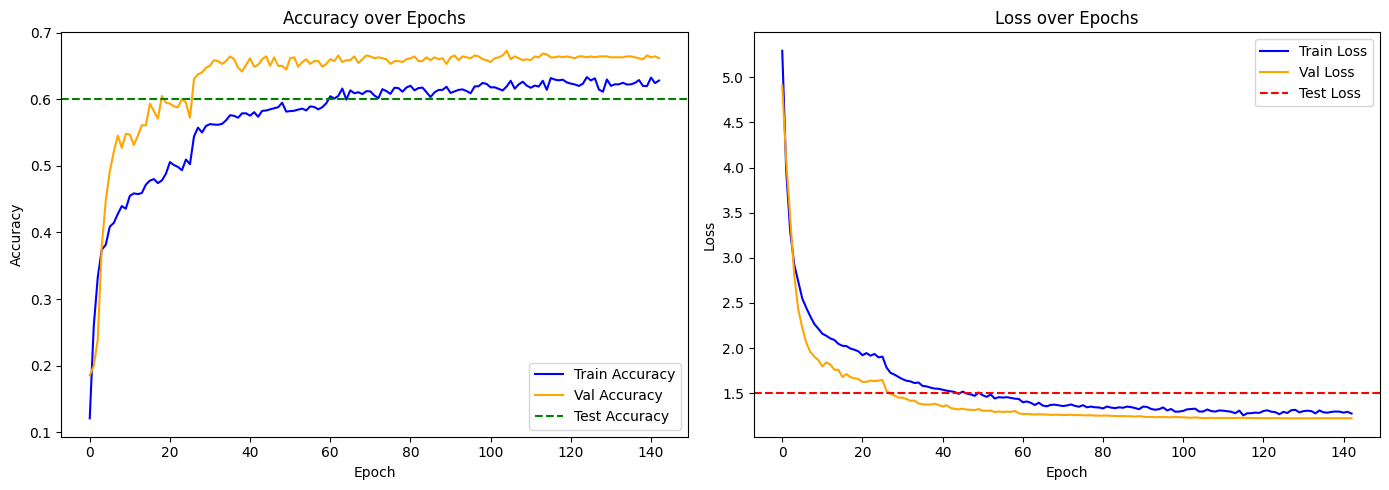

In [13]:
def plot_history(history, test_acc=None, test_loss=None):
    plt.figure(figsize=(14, 5))

    # === Accuracy ===
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy', color='blue')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy', color='orange')
    if test_acc is not None:
        plt.axhline(test_acc, color='green', linestyle='--', label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy over Epochs')
    plt.legend()

    # === Loss ===
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss', color='blue')
    plt.plot(history.history['val_loss'], label='Val Loss', color='orange')
    if test_loss is not None:
        plt.axhline(test_loss, color='red', linestyle='--', label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Вызов
plot_history(history, test_acc=test_acc, test_loss=test_loss)

In [14]:
# Убедимся, что у нас есть предсказания
y_pred = final_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Подробный отчет по всем person_id (классам)
report = classification_report(y_test, y_pred_classes, zero_division=0, output_dict=True)

# Преобразуем в DataFrame для удобства и сортировки
import pandas as pd

report_df = pd.DataFrame(report).transpose()

# Фильтруем только классы (исключим avg / accuracy строки)
user_class_metrics = report_df[report_df.index.str.isnumeric()].astype(float)

# Сортируем по F1 для анализа
user_class_metrics = user_class_metrics.sort_values(by='f1-score', ascending=False)

# Вывод топ-15
print(user_class_metrics.head(15))

23/23 [==============================] - 0s 2ms/step
    precision  recall  f1-score  support
25   1.000000     1.0  1.000000      1.0
47   1.000000     1.0  1.000000      7.0
29   1.000000     1.0  1.000000     12.0
54   1.000000     1.0  1.000000      1.0
16   1.000000     1.0  1.000000      8.0
73   1.000000     1.0  1.000000      1.0
74   1.000000     1.0  1.000000      6.0
11   1.000000     1.0  1.000000      7.0
40   1.000000     1.0  1.000000      1.0
87   1.000000     1.0  1.000000      3.0
78   1.000000     1.0  1.000000      4.0
52   1.000000     1.0  1.000000     13.0
83   0.875000     1.0  0.933333      7.0
30   0.833333     1.0  0.909091      5.0
85   1.000000     0.8  0.888889      5.0


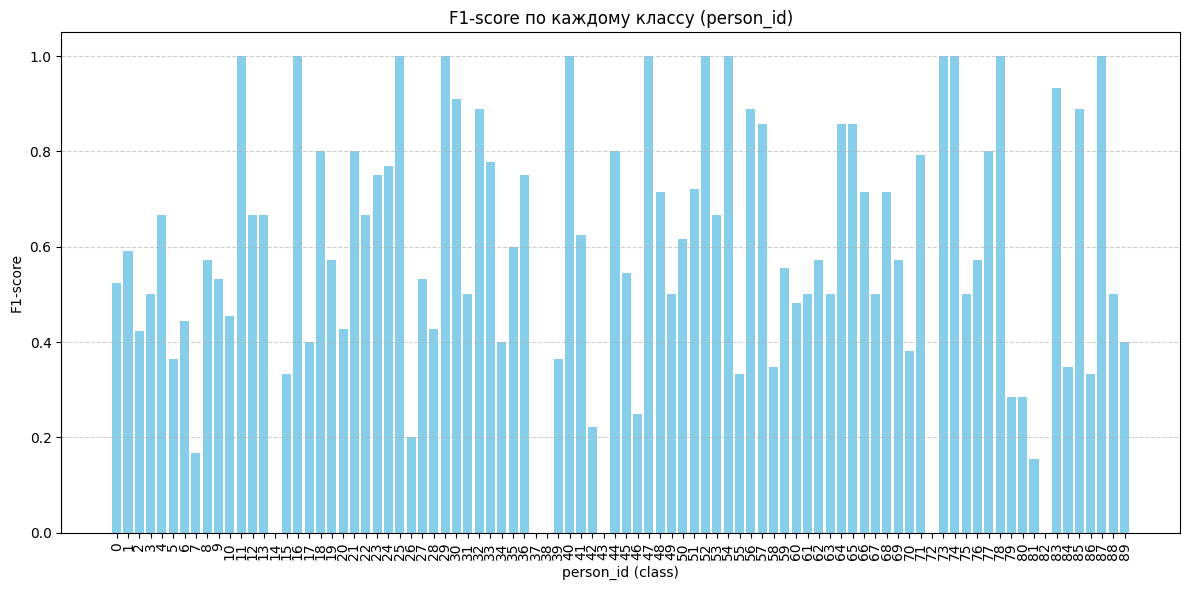

In [15]:
# Формируем отчёт
report = classification_report(y_test, y_pred_classes, output_dict=True, zero_division=0)
report_df = pd.DataFrame(report).transpose()
user_class_metrics = report_df[report_df.index.str.isnumeric()].astype(float)

# Строим распределение F1-score
plt.figure(figsize=(12, 6))
plt.bar(user_class_metrics.index, user_class_metrics['f1-score'], color='skyblue')
plt.xticks(rotation=90)
plt.xlabel('person_id (class)')
plt.ylabel('F1-score')
plt.title('F1-score по каждому классу (person_id)')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

In [16]:
# Получаем признаки и метки по всем сегментам
X_segments = descriptors_df.to_numpy(dtype=np.float32)
y_segments = labels_df['person_id'].to_numpy()

# Масштабируем дескрипторы тем же скейлером, что использовался при обучении
X_segments_scaled = scaler.transform(X_segments)  # scaler должен быть уже обучен

# Прогон через обученную модель
y_pred_segments = np.argmax(final_model.predict(X_segments_scaled), axis=1)

# F1 macro по всем сегментам
f1_segments = f1_score(y_segments, y_pred_segments, average='macro')
print(f"\nF1-score по всем сегментам: {f1_segments:.4f}")

# Отчёт по каждому классу
print("\nClassification report по всем сегментам:")
print(classification_report(y_segments, y_pred_segments, zero_division=0))

221/221 [==============================] - 1s 2ms/step

F1-score по всем сегментам: 0.7184

Classification report по всем сегментам:
              precision    recall  f1-score   support

           0       0.69      0.75      0.72       463
           1       0.66      0.75      0.70       516
           2       0.61      0.55      0.58       110
           3       0.61      0.57      0.59        44
           4       0.56      0.85      0.67        34
           5       0.66      0.48      0.55        44
           6       0.69      0.63      0.66        43
           7       0.67      0.62      0.64        55
           8       0.79      0.74      0.76       131
           9       0.74      0.66      0.70       130
          10       0.51      0.67      0.58        69
          11       0.95      0.98      0.96        55
          12       0.77      0.59      0.67        17
          13       0.68      0.91      0.78        44
          14       0.50      0.67      0.57        24
  

In [17]:
final_model.summary()

Model: "ECGPersonIdentifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_100 (Dense)           (None, 353)               5295      
                                                                 
 batch_normalization_60 (Ba  (None, 353)               1412      
 tchNormalization)                                               
                                                                 
 dropout_60 (Dropout)        (None, 353)               0         
                                                                 
 dense_101 (Dense)           (None, 146)               51684     
                                                                 
 batch_normalization_61 (Ba  (None, 146)               584       
 tchNormalization)                                               
                                                                 
 dropout_61 (Dropout)        (None, 146)       

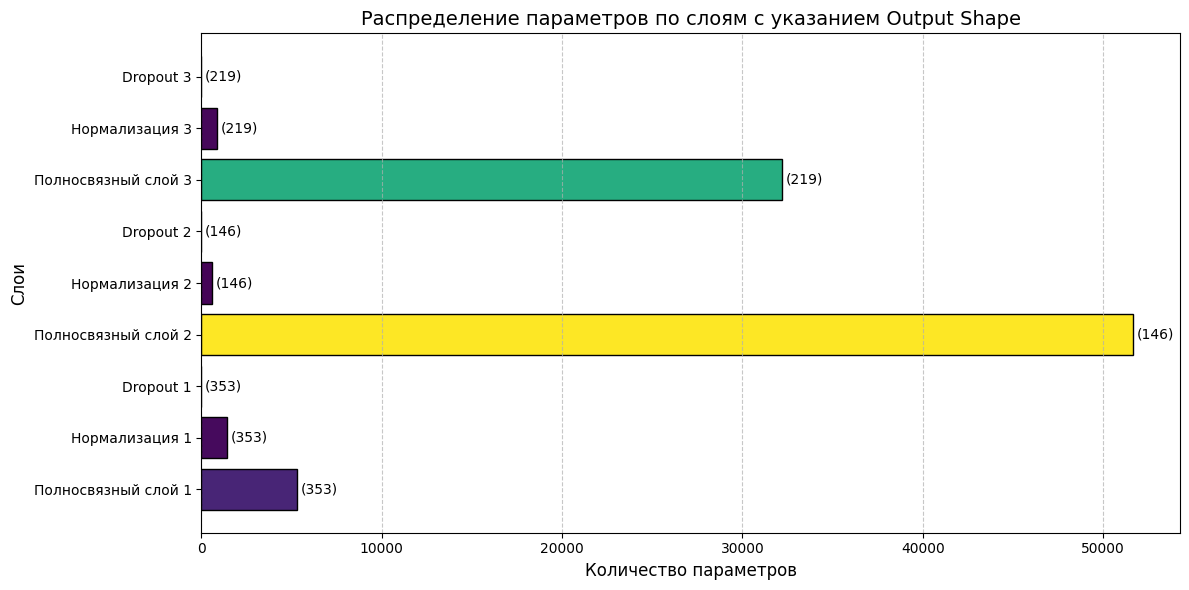

In [19]:
# Данные о слоях (соответствуют новой модели ECGPersonIdentifier)
layers = [
    {"name": "Полносвязный слой 1", "params": 5295, "output_shape": "(353)"},
    {"name": "Нормализация 1", "params": 1412, "output_shape": "(353)"},
    {"name": "Dropout 1", "params": 0, "output_shape": "(353)"},
    {"name": "Полносвязный слой 2", "params": 51684, "output_shape": "(146)"},
    {"name": "Нормализация 2", "params": 584, "output_shape": "(146)"},
    {"name": "Dropout 2", "params": 0, "output_shape": "(146)"},
    {"name": "Полносвязный слой 3", "params": 32193, "output_shape": "(219)"},
    {"name": "Нормализация 3", "params": 876, "output_shape": "(219)"},
    {"name": "Dropout 3", "params": 0, "output_shape": "(219)"},
]

# Извлекаем данные
layer_names = [layer["name"] for layer in layers]
params = [layer["params"] for layer in layers]
output_shapes = [layer["output_shape"] for layer in layers]

# Построение горизонтальной гистограммы
plt.figure(figsize=(12, 6))
colors = plt.cm.viridis([x / max(params) if max(params) > 0 else 0 for x in params])  # Градиент цвета
bars = plt.barh(layer_names, params, color=colors, edgecolor="black")

# Добавляем информацию о Output Shape на график
for bar, shape in zip(bars, output_shapes):
    plt.text(
        bar.get_width() + 200,  # Позиция текста справа от столбца
        bar.get_y() + bar.get_height() / 2,
        f"{shape}",  # Форма выхода
        va="center", fontsize=10, color="black"
    )

# Настройки графика
plt.xlabel("Количество параметров", fontsize=12)
plt.ylabel("Слои", fontsize=12)
plt.title("Распределение параметров по слоям с указанием Output Shape", fontsize=14)
plt.grid(axis="x", linestyle="--", alpha=0.7)

# Отображаем график
plt.tight_layout()
plt.show()

In [21]:
# Убедимся, что папка ресурсов существует
os.makedirs("../resources", exist_ok=True)

# Сохраняем модель
model_path = "../resources/ecg_classifier.keras"
final_model.save(model_path)
print(f"✅ Модель сохранена в: {model_path}")

# Сохраняем scaler
scaler_path = "../resources/scaler.joblib"
dump(scaler, scaler_path)
print(f"✅ Scaler сохранён в: {scaler_path}")

# Сохраняем архитектуру модели
arch_path = "../resources/model_architecture.txt"
with open(arch_path, "w", encoding="utf-8") as f:
    final_model.summary(print_fn=lambda x: f.write(x + "\n"))
print(f"✅ Архитектура модели сохранена в: {arch_path}")


✅ Модель сохранена в: ../resources/ecg_classifier.keras
✅ Scaler сохранён в: ../resources/scaler.joblib
✅ Архитектура модели сохранена в: ../resources/model_architecture.txt


Ручная настройка параметров

Epoch 1/150


C:\Users\Digital Razor\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.0603 - loss: 5.2192 - val_accuracy: 0.1473 - val_loss: 4.6276 - learning_rate: 0.0010
Epoch 2/150
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2157 - loss: 4.0191 - val_accuracy: 0.2167 - val_loss: 3.8243 - learning_rate: 0.0010
Epoch 3/150
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2974 - loss: 3.3374 - val_accuracy: 0.2975 - val_loss: 3.2252 - learning_rate: 0.0010
Epoch 4/150
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3415 - loss: 3.0179 - val_accuracy: 0.3966 - val_loss: 2.7214 - learning_rate: 0.0010
Epoch 5/150
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3724 - loss: 2.8258 - val_accuracy: 0.4547 - val_loss: 2.4339 - learning_rate: 0.0010
Epoch 6/150
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3919 - loss: 2.7289 - val_accuracy: 0.4958 - val_loss: 2.2735 - learning_rate: 0.0010
Epoch 7/150
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4204 - loss: 2.6093 - val_accuracy: 0.524

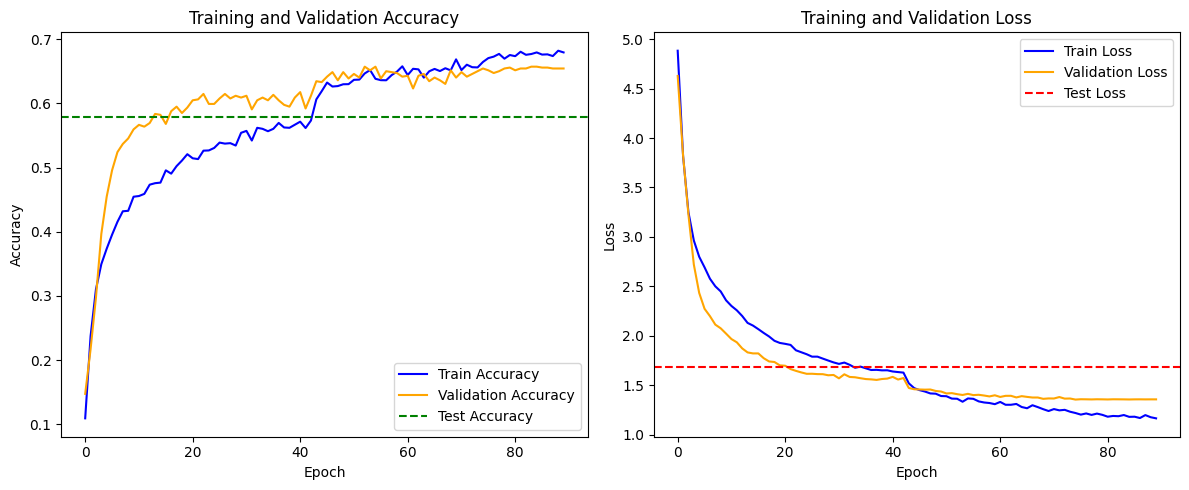

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.55      0.56        51
           1       0.48      0.65      0.56        49
           2       0.33      0.24      0.28        17
           3       0.67      0.50      0.57         4
           4       0.50      1.00      0.67         1
           5       0.67      0.25      0.36         8
           6       0.50      0.60      0.55         5
           7       0.14      0.17      0.15         6
           8       0.62      0.57      0.59        14
           9       0.50      0.38      0.43        16
          10       0.50      0.40      0.44        10
          11       1.00      0.86      0.92         7
          12       1.00      0.50      0.67         2
          13       0.60      0.60      0.60         5
          14       0.00      0.00      0.00         1
          15       0.22      0.18      0.20        11
          16      

C:\Users\Digital Razor\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Digital Razor\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Digital Razor\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklea

In [91]:
# Параметры обучения
BATCH_SIZE = 64
EPOCHS = 150

# Фиксируем случайное состояние для воспроизводимости
reset_rand_seed()

# Создаем модель
model = create_deep_model((X_train.shape[1],), len(np.unique(y_train)))

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
]

# Обучение модели
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),  # Используем валидационную выборку
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    verbose=1
)

# Визуализация процесса обучения с учетом тестовых метрик
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"\nTest Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# Визуализация истории обучения, включая тестовые метрики
plot_training_history(history, test_accuracy=test_acc, test_loss=test_loss)

# Предсказания и дополнительные метрики
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes))


----

# Обучение с переводом меток класса в категориальные ("one-hot encoding") и перемешиванием выборок

In [ ]:
# Преобразуем DataFrame descriptors_df в массив numpy с типом данных float
X = descriptors_df.to_numpy(dtype=float)
# Преобразуем DataFrame labels_df в одномерный массив numpy с типом данных int и "развертываем" массив
y = labels_df.to_numpy(dtype=int).flatten()

# Разделяем данные на тренировочную, тестовую и валидационную выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
X_test, X_val, y_test, y_val = train_test_split(
    X_test, y_test, test_size=0.5, random_state=42
)

# Стандартизируем данные и перезаписываем переменные
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  # Перезаписываем X_train
X_test = scaler.transform(X_test)        # Перезаписываем X_test
X_val = scaler.transform(X_val)          # Перезаписываем X_val

# Перезаписываем y в категориальный формат
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

# Выводим размерности массивов категориальных меток
print(f"Форма y_train: {y_train.shape}")
print(f"Форма y_test: {y_test.shape}")
print(f"Форма y_val: {y_val.shape}")

Форма y_train: (5643, 90)
Форма y_test: (705, 90)
Форма y_val: (706, 90)


In [ ]:
# Перемешиваем данные X_train и y_train синхронно
indices_train = np.arange(X_train.shape[0])  # Создаем массив индексов для тренировочной выборки
np.random.shuffle(indices_train)  # Перемешиваем индексы для тренировочной выборки

# Применяем перемешанные индексы к данным
X_train = X_train[indices_train]
y_train = y_train[indices_train]

# Перемешиваем данные X_val и y_val синхронно (опционально)
indices_val = np.arange(X_val.shape[0])  # Создаем массив индексов для валидационной выборки
np.random.shuffle(indices_val)  # Перемешиваем индексы для валидационной выборки

# Применяем перемешанные индексы к валидационным данным
X_val = X_val[indices_val]
y_val = y_val[indices_val]

# Перемешиваем данные X_test и y_test синхронно
indices_test = np.arange(X_test.shape[0])  # Создаем массив индексов для тестовой выборки
np.random.shuffle(indices_test)  # Перемешиваем индексы для тестовой выборки

# Применяем перемешанные индексы к данным
X_test = X_test[indices_test]
y_test = y_test[indices_test]


Доступные GPU: []
Epoch 1/150


C:\Users\Digital Razor\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.0614 - loss: 5.1781 - val_accuracy: 0.0949 - val_loss: 4.6270 - learning_rate: 0.0010
Epoch 2/150
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2069 - loss: 3.9412 - val_accuracy: 0.1983 - val_loss: 3.7621 - learning_rate: 0.0010
Epoch 3/150
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3089 - loss: 3.2897 - val_accuracy: 0.3314 - val_loss: 3.1232 - learning_rate: 0.0010
Epoch 4/150
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3478 - loss: 2.9902 - val_accuracy: 0.4249 - val_loss: 2.6768 - learning_rate: 0.0010
Epoch 5/150
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3878 - loss: 2.7958 - val_accuracy: 0.4958 - val_loss: 2.3967 - learning_rate: 0.0010
Epoch 6/150
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3897 - loss: 2.6883 - val_accuracy: 0.4958 - val_loss: 2.2671 - learning_rate: 0.0010
Epoch 7/150
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4190 - loss: 2.5987 - val_accuracy: 0.534

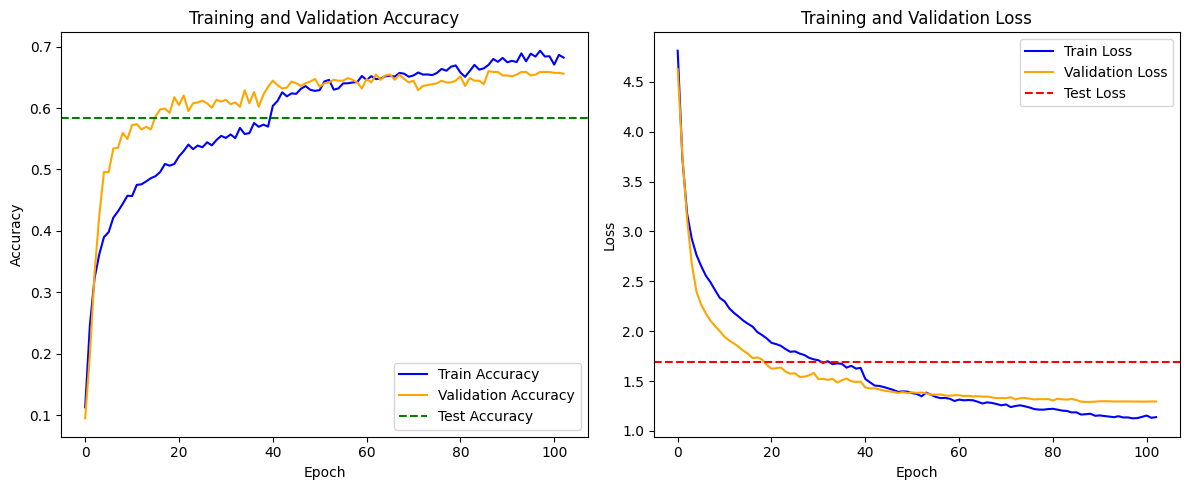

In [ ]:
# Функция для создания глубокой модели нейронной сети
def create_deep_model(input_shape, num_classes):
    """
    Создает глубокую нейронную сеть с регуляризацией L2, нормализацией батчей и dropout.
    
    :param input_shape: форма входных данных (например, (features,))
    :param num_classes: количество классов для классификации
    :return: скомпилированная модель Keras
    """
    model = Sequential([
        # Первый полносвязный слой с регуляризацией L2
        Dense(512, activation='relu', input_shape=input_shape,
              kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        BatchNormalization(),
        Dropout(0.5),
        
        # Второй полносвязный слой с регуляризацией L2
        Dense(256, activation='relu',
              kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        BatchNormalization(),
        Dropout(0.4),
        
        # Третий полносвязный слой с регуляризацией L2
        Dense(256, activation='relu',
              kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        BatchNormalization(),
        Dropout(0.3),
        
        # Четвертый полносвязный слой с регуляризацией L2
        Dense(128, activation='relu',
              kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        BatchNormalization(),
        Dropout(0.2),
        
        # Пятый полносвязный слой без регуляризации
        Dense(128, activation='relu'),
        # Выходной слой с функцией активации 'softmax' для многоклассовой классификации
        Dense(90, activation='softmax')
    ])
    
    # Оптимизатор Adam с заданной скоростью обучения
    optimizer = Adam(learning_rate=0.001)
    
    # Компиляция модели с использованием функции потерь categorical_crossentropy и метрики accuracy
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Функция для визуализации истории обучения
def plot_training_history(history, test_accuracy=None, test_loss=None):
    """
    Визуализирует историю обучения модели, включая точность и потери.
    Также может отображать тестовые метрики пунктирными линиями.
    
    :param history: объект history, возвращаемый model.fit()
    :param test_accuracy: точность на тестовой выборке (опционально)
    :param test_loss: потери на тестовой выборке (опционально)
    """
    plt.figure(figsize=(12, 5))
    
    # График точности
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy', color='blue')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
    
    # Добавление пунктирной линии для тестовой точности
    if test_accuracy is not None:
        plt.axhline(y=test_accuracy, color='green', linestyle='--', label='Test Accuracy')
    
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # График потерь
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss', color='blue')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
    
    # Добавление пунктирной линии для тестовых потерь
    if test_loss is not None:
        plt.axhline(y=test_loss, color='red', linestyle='--', label='Test Loss')
    
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
# Параметры обучения
BATCH_SIZE = 64
EPOCHS = 150

# Фиксируем случайное состояние для воспроизводимости
reset_rand_seed()

# Создаем модель
model = create_deep_model((X_train.shape[1],), len(np.unique(y_train)))

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
]

# Обучение модели
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),  # Используем валидационную выборку
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    verbose=1
)

# Визуализация процесса обучения с учетом тестовых метрик
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"\nTest Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# Визуализация истории обучения, включая тестовые метрики
plot_training_history(history, test_accuracy=test_acc, test_loss=test_loss)


---

# 3. Pytorch

[I 2025-04-02 17:14:33,336] A new study created in memory with name: no-name-5126bb99-401d-4a21-9303-c2752ffd878e
[I 2025-04-02 17:14:37,384] Trial 0 finished with value: 3.348964293797811 and parameters: {'hidden_size1': 256, 'hidden_size2': 96, 'hidden_size3': 48, 'dropout_prob': 0.45, 'learning_rate': 0.00014825580040801992, 'weight_decay': 2.619299661937191e-05, 'batch_size': 128}. Best is trial 0 with value: 3.348964293797811.


Trial 0:
  Validation Loss: 3.3490
  Params: hidden_size1=256, hidden_size2=96, hidden_size3=48, dropout_prob=0.45, learning_rate=0.00014825580040801992, weight_decay=2.619299661937191e-05, batch_size=128
--------------------------------------------------


[I 2025-04-02 17:14:47,953] Trial 1 finished with value: 1.6505866517191348 and parameters: {'hidden_size1': 128, 'hidden_size2': 192, 'hidden_size3': 112, 'dropout_prob': 0.45, 'learning_rate': 0.0007637685624778917, 'weight_decay': 7.495687978930279e-05, 'batch_size': 32}. Best is trial 1 with value: 1.6505866517191348.


Trial 1:
  Validation Loss: 1.6506
  Params: hidden_size1=128, hidden_size2=192, hidden_size3=112, dropout_prob=0.45, learning_rate=0.0007637685624778917, weight_decay=7.495687978930279e-05, batch_size=32
--------------------------------------------------


[I 2025-04-02 17:14:53,975] Trial 2 finished with value: 1.2727599889039993 and parameters: {'hidden_size1': 320, 'hidden_size2': 192, 'hidden_size3': 112, 'dropout_prob': 0.2, 'learning_rate': 0.0018904794261537811, 'weight_decay': 0.0001913674704550968, 'batch_size': 96}. Best is trial 2 with value: 1.2727599889039993.


Trial 2:
  Validation Loss: 1.2728
  Params: hidden_size1=320, hidden_size2=192, hidden_size3=112, dropout_prob=0.2, learning_rate=0.0018904794261537811, weight_decay=0.0001913674704550968, batch_size=96
--------------------------------------------------


[I 2025-04-02 17:14:58,669] Trial 3 finished with value: 1.8050262480974197 and parameters: {'hidden_size1': 256, 'hidden_size2': 96, 'hidden_size3': 96, 'dropout_prob': 0.4, 'learning_rate': 0.000561085216077106, 'weight_decay': 3.9255369987207304e-05, 'batch_size': 96}. Best is trial 2 with value: 1.2727599889039993.


Trial 3:
  Validation Loss: 1.8050
  Params: hidden_size1=256, hidden_size2=96, hidden_size3=96, dropout_prob=0.4, learning_rate=0.000561085216077106, weight_decay=3.9255369987207304e-05, batch_size=96
--------------------------------------------------


[I 2025-04-02 17:15:07,414] Trial 4 finished with value: 2.661131270726522 and parameters: {'hidden_size1': 384, 'hidden_size2': 96, 'hidden_size3': 64, 'dropout_prob': 0.45, 'learning_rate': 0.00013096942751885914, 'weight_decay': 2.5864459979343408e-05, 'batch_size': 48}. Best is trial 2 with value: 1.2727599889039993.


Trial 4:
  Validation Loss: 2.6611
  Params: hidden_size1=384, hidden_size2=96, hidden_size3=64, dropout_prob=0.45, learning_rate=0.00013096942751885914, weight_decay=2.5864459979343408e-05, batch_size=48
--------------------------------------------------


[I 2025-04-02 17:15:16,240] Trial 5 finished with value: 1.988229513168335 and parameters: {'hidden_size1': 512, 'hidden_size2': 192, 'hidden_size3': 96, 'dropout_prob': 0.30000000000000004, 'learning_rate': 0.00015279507230777503, 'weight_decay': 3.0326125542838584e-05, 'batch_size': 64}. Best is trial 2 with value: 1.2727599889039993.


Trial 5:
  Validation Loss: 1.9882
  Params: hidden_size1=512, hidden_size2=192, hidden_size3=96, dropout_prob=0.30000000000000004, learning_rate=0.00015279507230777503, weight_decay=3.0326125542838584e-05, batch_size=64
--------------------------------------------------


[I 2025-04-02 17:15:27,423] Trial 6 finished with value: 1.4031054337819417 and parameters: {'hidden_size1': 512, 'hidden_size2': 160, 'hidden_size3': 128, 'dropout_prob': 0.45, 'learning_rate': 0.0036231669332060686, 'weight_decay': 0.00030803769217558605, 'batch_size': 48}. Best is trial 2 with value: 1.2727599889039993.


Trial 6:
  Validation Loss: 1.4031
  Params: hidden_size1=512, hidden_size2=160, hidden_size3=128, dropout_prob=0.45, learning_rate=0.0036231669332060686, weight_decay=0.00030803769217558605, batch_size=48
--------------------------------------------------


[I 2025-04-02 17:15:35,815] Trial 7 finished with value: 1.443112423022588 and parameters: {'hidden_size1': 384, 'hidden_size2': 160, 'hidden_size3': 96, 'dropout_prob': 0.45, 'learning_rate': 0.0033873513308445595, 'weight_decay': 5.5403370880610374e-05, 'batch_size': 64}. Best is trial 2 with value: 1.2727599889039993.


Trial 7:
  Validation Loss: 1.4431
  Params: hidden_size1=384, hidden_size2=160, hidden_size3=96, dropout_prob=0.45, learning_rate=0.0033873513308445595, weight_decay=5.5403370880610374e-05, batch_size=64
--------------------------------------------------


[I 2025-04-02 17:15:46,286] Trial 8 finished with value: 2.155941579652869 and parameters: {'hidden_size1': 256, 'hidden_size2': 96, 'hidden_size3': 48, 'dropout_prob': 0.2, 'learning_rate': 0.00012984304907844802, 'weight_decay': 1.1813650886533697e-05, 'batch_size': 32}. Best is trial 2 with value: 1.2727599889039993.


Trial 8:
  Validation Loss: 2.1559
  Params: hidden_size1=256, hidden_size2=96, hidden_size3=48, dropout_prob=0.2, learning_rate=0.00012984304907844802, weight_decay=1.1813650886533697e-05, batch_size=32
--------------------------------------------------


[I 2025-04-02 17:15:53,034] Trial 9 finished with value: 2.8721211155255637 and parameters: {'hidden_size1': 256, 'hidden_size2': 128, 'hidden_size3': 32, 'dropout_prob': 0.25, 'learning_rate': 0.00011228541446662397, 'weight_decay': 6.822443074868134e-05, 'batch_size': 64}. Best is trial 2 with value: 1.2727599889039993.


Trial 9:
  Validation Loss: 2.8721
  Params: hidden_size1=256, hidden_size2=128, hidden_size3=32, dropout_prob=0.25, learning_rate=0.00011228541446662397, weight_decay=6.822443074868134e-05, batch_size=64
--------------------------------------------------


[I 2025-04-02 17:15:58,233] Trial 10 finished with value: 1.2812210832323347 and parameters: {'hidden_size1': 128, 'hidden_size2': 256, 'hidden_size3': 128, 'dropout_prob': 0.2, 'learning_rate': 0.007946738730784983, 'weight_decay': 0.0007812560687296126, 'batch_size': 112}. Best is trial 2 with value: 1.2727599889039993.


Trial 10:
  Validation Loss: 1.2812
  Params: hidden_size1=128, hidden_size2=256, hidden_size3=128, dropout_prob=0.2, learning_rate=0.007946738730784983, weight_decay=0.0007812560687296126, batch_size=112
--------------------------------------------------


[I 2025-04-02 17:16:03,064] Trial 11 finished with value: 1.249025481087821 and parameters: {'hidden_size1': 128, 'hidden_size2': 256, 'hidden_size3': 128, 'dropout_prob': 0.2, 'learning_rate': 0.0086470644181328, 'weight_decay': 0.000680158658319826, 'batch_size': 112}. Best is trial 11 with value: 1.249025481087821.


Trial 11:
  Validation Loss: 1.2490
  Params: hidden_size1=128, hidden_size2=256, hidden_size3=128, dropout_prob=0.2, learning_rate=0.0086470644181328, weight_decay=0.000680158658319826, batch_size=112
--------------------------------------------------


[I 2025-04-02 17:16:11,254] Trial 12 finished with value: 1.2982367873191833 and parameters: {'hidden_size1': 384, 'hidden_size2': 256, 'hidden_size3': 128, 'dropout_prob': 0.30000000000000004, 'learning_rate': 0.0017829918026392678, 'weight_decay': 0.00018804450217462402, 'batch_size': 96}. Best is trial 11 with value: 1.249025481087821.


Trial 12:
  Validation Loss: 1.2982
  Params: hidden_size1=384, hidden_size2=256, hidden_size3=128, dropout_prob=0.30000000000000004, learning_rate=0.0017829918026392678, weight_decay=0.00018804450217462402, batch_size=96
--------------------------------------------------


[I 2025-04-02 17:16:16,153] Trial 13 finished with value: 1.4063668648401897 and parameters: {'hidden_size1': 192, 'hidden_size2': 224, 'hidden_size3': 112, 'dropout_prob': 0.25, 'learning_rate': 0.009965930507783022, 'weight_decay': 0.0009906691765301683, 'batch_size': 128}. Best is trial 11 with value: 1.249025481087821.


Trial 13:
  Validation Loss: 1.4064
  Params: hidden_size1=192, hidden_size2=224, hidden_size3=112, dropout_prob=0.25, learning_rate=0.009965930507783022, weight_decay=0.0009906691765301683, batch_size=128
--------------------------------------------------


[I 2025-04-02 17:16:23,340] Trial 14 finished with value: 1.3306028544902802 and parameters: {'hidden_size1': 448, 'hidden_size2': 224, 'hidden_size3': 112, 'dropout_prob': 0.35000000000000003, 'learning_rate': 0.0017984202529477678, 'weight_decay': 0.0003861438628990577, 'batch_size': 96}. Best is trial 11 with value: 1.249025481087821.


Trial 14:
  Validation Loss: 1.3306
  Params: hidden_size1=448, hidden_size2=224, hidden_size3=112, dropout_prob=0.35000000000000003, learning_rate=0.0017984202529477678, weight_decay=0.0003861438628990577, batch_size=96
--------------------------------------------------


[I 2025-04-02 17:16:29,824] Trial 15 finished with value: 1.635780658040728 and parameters: {'hidden_size1': 320, 'hidden_size2': 224, 'hidden_size3': 80, 'dropout_prob': 0.2, 'learning_rate': 0.0003769052162036807, 'weight_decay': 0.00015264516135972712, 'batch_size': 112}. Best is trial 11 with value: 1.249025481087821.


Trial 15:
  Validation Loss: 1.6358
  Params: hidden_size1=320, hidden_size2=224, hidden_size3=80, dropout_prob=0.2, learning_rate=0.0003769052162036807, weight_decay=0.00015264516135972712, batch_size=112
--------------------------------------------------


[I 2025-04-02 17:16:36,700] Trial 16 finished with value: 1.2911732461717393 and parameters: {'hidden_size1': 192, 'hidden_size2': 192, 'hidden_size3': 80, 'dropout_prob': 0.25, 'learning_rate': 0.004225108338438503, 'weight_decay': 0.0005262192471875255, 'batch_size': 80}. Best is trial 11 with value: 1.249025481087821.


Trial 16:
  Validation Loss: 1.2912
  Params: hidden_size1=192, hidden_size2=192, hidden_size3=80, dropout_prob=0.25, learning_rate=0.004225108338438503, weight_decay=0.0005262192471875255, batch_size=80
--------------------------------------------------


[I 2025-04-02 17:16:42,504] Trial 17 finished with value: 1.38001891544887 and parameters: {'hidden_size1': 192, 'hidden_size2': 256, 'hidden_size3': 112, 'dropout_prob': 0.30000000000000004, 'learning_rate': 0.0013026151343366963, 'weight_decay': 0.00014536739825610236, 'batch_size': 112}. Best is trial 11 with value: 1.249025481087821.


Trial 17:
  Validation Loss: 1.3800
  Params: hidden_size1=192, hidden_size2=256, hidden_size3=112, dropout_prob=0.30000000000000004, learning_rate=0.0013026151343366963, weight_decay=0.00014536739825610236, batch_size=112
--------------------------------------------------


[I 2025-04-02 17:16:50,096] Trial 18 finished with value: 1.4541890488730536 and parameters: {'hidden_size1': 320, 'hidden_size2': 64, 'hidden_size3': 128, 'dropout_prob': 0.35000000000000003, 'learning_rate': 0.004723054332442873, 'weight_decay': 0.0002498886685416492, 'batch_size': 80}. Best is trial 11 with value: 1.249025481087821.


Trial 18:
  Validation Loss: 1.4542
  Params: hidden_size1=320, hidden_size2=64, hidden_size3=128, dropout_prob=0.35000000000000003, learning_rate=0.004723054332442873, weight_decay=0.0002498886685416492, batch_size=80
--------------------------------------------------


[I 2025-04-02 17:17:04,304] Trial 19 finished with value: 1.640899313820733 and parameters: {'hidden_size1': 448, 'hidden_size2': 224, 'hidden_size3': 96, 'dropout_prob': 0.25, 'learning_rate': 0.00033783780337655686, 'weight_decay': 0.0005262266974182191, 'batch_size': 80}. Best is trial 11 with value: 1.249025481087821.


Trial 19:
  Validation Loss: 1.6409
  Params: hidden_size1=448, hidden_size2=224, hidden_size3=96, dropout_prob=0.25, learning_rate=0.00033783780337655686, weight_decay=0.0005262266974182191, batch_size=80
--------------------------------------------------

Лучшие параметры:
{'hidden_size1': 128, 'hidden_size2': 256, 'hidden_size3': 128, 'dropout_prob': 0.2, 'learning_rate': 0.0086470644181328, 'weight_decay': 0.000680158658319826, 'batch_size': 112}
Лучшая валидационная потеря: 1.2490

Starting training with best parameters:
Hidden sizes: 128, 256, 128
Dropout probability: 0.2, Learning rate: 0.0086470644181328
Weight decay: 0.000680158658319826, Batch size: 112
--------------------------------------------------
Epoch 1/50:
  Train Loss: 3.2194, Train Accuracy: 20.73%
  Val Loss: 2.2422, Val Accuracy: 36.69%
--------------------------------------------------
Epoch 2/50:
  Train Loss: 2.2767, Train Accuracy: 33.55%
  Val Loss: 1.8912, Val Accuracy: 45.47%
------------------------------

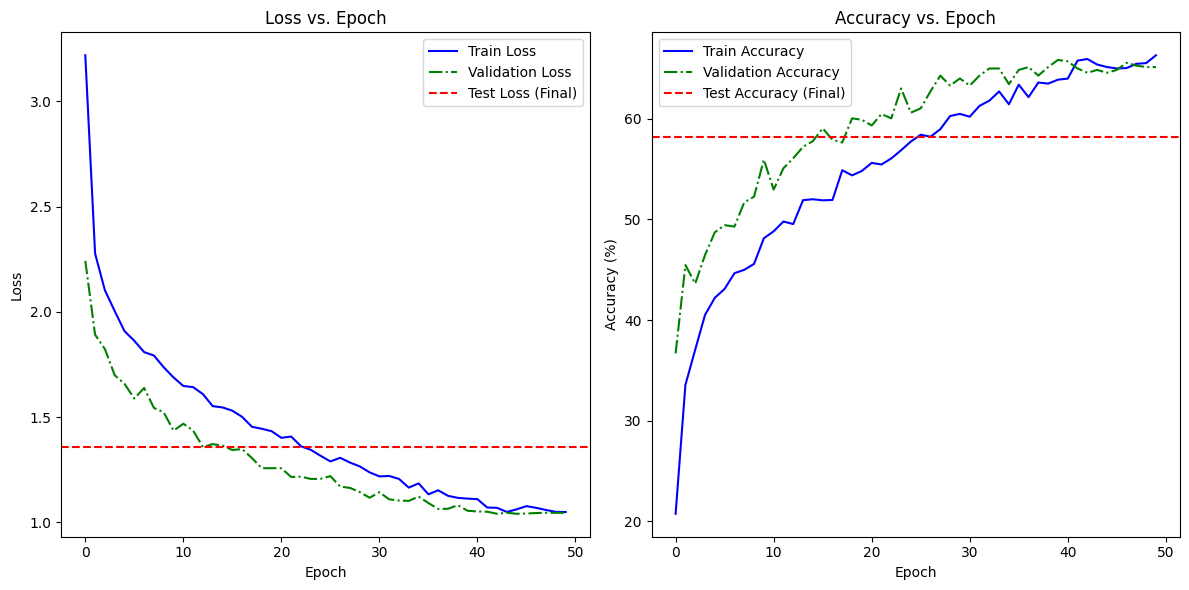

Final Test Loss: 1.3583, Final Test Accuracy: 58.16%
Final Test Loss: 1.3583, Final Test Accuracy: 58.16%


In [ ]:
# Определение модели нейронной сети с Dropout
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, output_size, dropout_prob=0.5):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.fc4 = nn.Linear(hidden_size3, output_size)
        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.fc4(x)
        return x

# Функция для загрузки данных
def load_data(X_train, X_test, X_val, y_train, y_test, y_val, batch_size):
    train_dataset = TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
    test_dataset = TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())
    val_dataset = TensorDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, test_loader, val_loader

# Функция для тестирования модели
def evaluate_model(model, data_loader, device):
    model.eval()
    total_loss = 0
    total_correct = 0
    
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = F.cross_entropy(outputs, labels)
            total_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total_correct += (predicted == labels).sum().item()
    
    avg_loss = total_loss / len(data_loader)
    avg_acc = total_correct / len(data_loader.dataset) * 100
    return avg_loss, avg_acc

# Функция для обучения модели
def train_model(model, train_loader, val_loader, test_loader, optimizer, scheduler, num_epochs, device):
    train_losses = []
    val_losses = []

    model.train()
    for epoch in range(num_epochs):
        epoch_loss = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = F.cross_entropy(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_train_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Валидация за эпоху
        model.eval()
        val_loss, _ = evaluate_model(model, val_loader, device)
        val_losses.append(val_loss)
        model.train()

        scheduler.step()

    return train_losses, val_losses

# Функция для оптимизации гиперпараметров с помощью Optuna
def objective(trial):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Определение гиперпараметров
    hidden_size1 = trial.suggest_int("hidden_size1", 128, 512, step=64)
    hidden_size2 = trial.suggest_int("hidden_size2", 64, 256, step=32)
    hidden_size3 = trial.suggest_int("hidden_size3", 32, 128, step=16)
    dropout_prob = trial.suggest_float("dropout_prob", 0.2, 0.5, step=0.05)
    learning_rate = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-5, 1e-3, log=True)
    batch_size = trial.suggest_int("batch_size", 32, 128, step=16)

    # Создание модели
    model = NeuralNetwork(input_size=X_train.shape[1], hidden_size1=hidden_size1,
                          hidden_size2=hidden_size2, hidden_size3=hidden_size3,
                          output_size=len(np.unique(y_train)), dropout_prob=dropout_prob).to(device)

    # Оптимизатор
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)

    # Создание DataLoader-ов
    train_loader, test_loader, val_loader = load_data(
        X_train, X_test, X_val, y_train, y_test, y_val, batch_size
    )

    # Обучение модели
    _, val_losses = train_model(model, train_loader, val_loader, test_loader, optimizer, scheduler, num_epochs=20, device=device)

    # Минимальная валидационная потеря
    min_val_loss = min(val_losses)

    # Вывод результатов текущей итерации
    print(f"Trial {trial.number}:")
    print(f"  Validation Loss: {min_val_loss:.4f}")
    print(f"  Params: hidden_size1={hidden_size1}, hidden_size2={hidden_size2}, hidden_size3={hidden_size3}, "
          f"dropout_prob={dropout_prob}, learning_rate={learning_rate}, weight_decay={weight_decay}, "
          f"batch_size={batch_size}")
    print("-" * 50)

    return min_val_loss

# Основная функция поиска гиперпараметров и обучения
def main():
    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=20)  # Количество итераций

    # Вывод лучших параметров и их результатов
    print("\nЛучшие параметры:")
    print(study.best_params)
    print(f"Лучшая валидационная потеря: {study.best_value:.4f}")

    # Финальное обучение с лучшими параметрами
    best_params = study.best_params
    train_with_best_params(best_params)

# Финальная функция обучения с отображением хода обучения
def train_with_best_params(best_params):
    hidden_size1 = best_params["hidden_size1"]
    hidden_size2 = best_params["hidden_size2"]
    hidden_size3 = best_params["hidden_size3"]
    dropout_prob = best_params["dropout_prob"]
    learning_rate = best_params["learning_rate"]
    weight_decay = best_params["weight_decay"]
    batch_size = best_params["batch_size"]

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = NeuralNetwork(
        input_size=X_train.shape[1],
        hidden_size1=hidden_size1,
        hidden_size2=hidden_size2,
        hidden_size3=hidden_size3,
        output_size=len(np.unique(y_train)),
        dropout_prob=dropout_prob
    ).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)

    train_loader, test_loader, val_loader = load_data(
        X_train, X_test, X_val, y_train, y_test, y_val, batch_size
    )

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    print("\nStarting training with best parameters:")
    print(f"Hidden sizes: {hidden_size1}, {hidden_size2}, {hidden_size3}")
    print(f"Dropout probability: {dropout_prob}, Learning rate: {learning_rate}")
    print(f"Weight decay: {weight_decay}, Batch size: {batch_size}")
    print("-" * 50)

    for epoch in range(50):
        epoch_loss = 0
        epoch_correct = 0
        model.train()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = F.cross_entropy(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            epoch_correct += (predicted == labels).sum().item()

        avg_train_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        avg_train_acc = epoch_correct / len(train_loader.dataset) * 100
        train_accuracies.append(avg_train_acc)

        val_loss, val_acc = evaluate_model(model, val_loader, device)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        scheduler.step()

        print(f"Epoch {epoch + 1}/50:")
        print(f"  Train Loss: {avg_train_loss:.4f}, Train Accuracy: {avg_train_acc:.2f}%")
        print(f"  Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.2f}%")
        print("-" * 50)

    test_loss, test_accuracy = evaluate_model(model, test_loader, device)

    plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies, test_loss, test_accuracy)

    print(f"Final Test Loss: {test_loss:.4f}, Final Test Accuracy: {test_accuracy:.2f}%")

# Функция для построения графиков
def plot_metrics(train_losses, val_losses, train_accuracies=None, val_accuracies=None, test_loss=None, test_accuracy=None):
    plt.figure(figsize=(12, 6))

    # График потерь
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="Train Loss", color="blue")
    plt.plot(val_losses, label="Validation Loss", color="green", linestyle="-.")
    if test_loss is not None:
        plt.axhline(y=test_loss, color="red", linestyle="--", label="Test Loss (Final)")
    plt.title("Loss vs. Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    # График точности
    if train_accuracies and val_accuracies:
        plt.subplot(1, 2, 2)
        plt.plot(train_accuracies, label="Train Accuracy", color="blue")
        plt.plot(val_accuracies, label="Validation Accuracy", color="green", linestyle="-.")
        if test_accuracy is not None:
            plt.axhline(y=test_accuracy, color="red", linestyle="--", label="Test Accuracy (Final)")
        plt.title("Accuracy vs. Epoch")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy (%)")
        plt.legend()

    plt.tight_layout()
    plt.show()

    if test_loss is not None and test_accuracy is not None:
        print(f"Final Test Loss: {test_loss:.4f}, Final Test Accuracy: {test_accuracy:.2f}%")

# Основная функция
def main():
    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=20)

    print("\nЛучшие параметры:")
    print(study.best_params)
    print(f"Лучшая валидационная потеря: {study.best_value:.4f}")

    # Финальное обучение с графиками и отображением хода обучения
    train_with_best_params(study.best_params)

if __name__ == "__main__":
    main()

